# Projeto Airbnb Rio - Ferramenta de Previsão de Preço de Imóvel para pessoas comuns

### Contexto

No Airbnb, qualquer pessoa que tenha um quarto ou um imóvel de qualquer tipo (apartamento, casa, chalé, pousada, etc.) pode ofertar o seu imóvel para ser alugado por diária.

Você cria o seu perfil de host (pessoa que disponibiliza um imóvel para aluguel por diária) e cria o anúncio do seu imóvel.

Nesse anúncio, o host deve descrever as características do imóvel da forma mais completa possível, de forma a ajudar os locadores/viajantes a escolherem o melhor imóvel para eles (e de forma a tornar o seu anúncio mais atrativo)

Existem dezenas de personalizações possíveis no seu anúncio, desde quantidade mínima de diária, preço, quantidade de quartos, até regras de cancelamento, taxa extra para hóspedes extras, exigência de verificação de identidade do locador, etc.

### Nosso objetivo

Construir um modelo de previsão de preço que permita uma pessoa comum que possui um imóvel possa saber quanto deve cobrar pela diária do seu imóvel.

Ou ainda, para o locador comum, dado o imóvel que ele está buscando, ajudar a saber se aquele imóvel está com preço atrativo (abaixo da média para imóveis com as mesmas características) ou não.

### O que temos disponível, inspirações e créditos

As bases de dados foram retiradas do site kaggle: https://www.kaggle.com/allanbruno/airbnb-rio-de-janeiro

Elas estão disponíveis para download abaixo da aula (se você puxar os dados direto do Kaggle pode ser que encontre resultados diferentes dos meus, afinal as bases de dados podem ter sido atualizadas).

Caso queira uma outra solução, podemos olhar como referência a solução do usuário Allan Bruno do kaggle no Notebook: https://www.kaggle.com/allanbruno/helping-regular-people-price-listings-on-airbnb

Você vai perceber semelhanças entre a solução que vamos desenvolver aqui e a dele, mas também algumas diferenças significativas no processo de construção do projeto.

- As bases de dados são os preços dos imóveis obtidos e suas respectivas características em cada mês.
- Os preços são dados em reais (R$)
- Temos bases de abril de 2018 a maio de 2020, com exceção de junho de 2018 que não possui base de dados

### Expectativas Iniciais

- Acredito que a sazonalidade pode ser um fator importante, visto que meses como dezembro costumam ser bem caros no RJ
- A localização do imóvel deve fazer muita diferença no preço, já que no Rio de Janeiro a localização pode mudar completamente as características do lugar (segurança, beleza natural, pontos turísticos)
- Adicionais/Comodidades podem ter um impacto significativo, visto que temos muitos prédios e casas antigos no Rio de Janeiro

Vamos descobrir o quanto esses fatores impactam e se temos outros fatores não tão intuitivos que são extremamente importantes.

### Importar Bibliotecas e Bases de Dados

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/2. Projeto de Ciência de Dados e Recomendações')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import pathlib as path
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [3]:
base_path = path.Path('dataset')
base_airbnb = pd.DataFrame()

mes = {'jan': 1, 'fev': 2, 'mar': 3, 'abr': 4, 'mai': 5, 'jun': 6, 'jul': 7, 'ago': 8, 'set': 9, 'out': 10, 'nov': 11, 'dez': 12}

for file in base_path.iterdir():
    month = file.name[:3]
    month = mes[month]

    year = int((file.name[-8:]).replace('.csv', ''))

    chunk_iter = pd.read_csv(base_path / file.name, chunksize=100000)
    for chunk in chunk_iter:
        chunk['month'] = month
        chunk['year'] = year
        base_airbnb = pd.concat([base_airbnb, chunk], ignore_index=True)

display(base_airbnb.head())

<ipython-input-3-f5390a6fe06e>:13: DtypeWarning: Columns (61,62,94) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in chunk_iter:
<ipython-input-3-f5390a6fe06e>:13: DtypeWarning: Columns (62,87) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in chunk_iter:
<ipython-input-3-f5390a6fe06e>:13: DtypeWarning: Columns (61,62,94) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in chunk_iter:
<ipython-input-3-f5390a6fe06e>:13: DtypeWarning: Columns (61,62,94) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in chunk_iter:
<ipython-input-3-f5390a6fe06e>:13: DtypeWarning: Columns (87) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in chunk_iter:
<ipython-input-3-f5390a6fe06e>:13: DtypeWarning: Columns (61,62,94) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in chunk_i

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,month,year
0,17878,https://www.airbnb.com/rooms/17878,20190923212307,2019-09-24,Very Nice 2Br - Copacabana - WiFi,Please note that special rates apply for Carni...,- large balcony which looks out on pedestrian ...,Please note that special rates apply for Carni...,none,This is the best spot in Rio. Everything happe...,...,strict_14_with_grace_period,f,f,1,1.0,0.0,0.0,2.13,9,2019
1,25026,https://www.airbnb.com/rooms/25026,20190923212307,2019-09-24,Beautiful Modern Decorated Studio in Copa,"Our apartment is a little gem, everyone loves ...",This newly renovated studio (last renovations ...,"Our apartment is a little gem, everyone loves ...",none,Copacabana is a lively neighborhood and the ap...,...,strict_14_with_grace_period,t,t,3,3.0,0.0,0.0,2.06,9,2019
2,31560,https://www.airbnb.com/rooms/31560,20190923212307,2019-09-24,NICE & COZY 1BDR - IPANEMA BEACH,This nice and clean 1 bedroom apartment is loc...,This nice and clean 1 bedroom apartment is loc...,This nice and clean 1 bedroom apartment is loc...,none,Die Nachbarschaft von Ipanema ist super lebend...,...,strict_14_with_grace_period,f,f,1,1.0,0.0,0.0,2.36,9,2019
3,35636,https://www.airbnb.com/rooms/35636,20190923212307,2019-09-24,Cosy flat close to Ipanema beach,This cosy apartment is just a few steps away ...,"The location is extremely convenient, safe and...",This cosy apartment is just a few steps away ...,none,The apartment street is very quiet and safe ....,...,strict_14_with_grace_period,t,t,1,1.0,0.0,0.0,2.25,9,2019
4,35764,https://www.airbnb.com/rooms/35764,20190923212307,2019-09-24,COPACABANA SEA BREEZE - RIO - 20 X Superhost,Our newly renovated studio is located in the b...,"FEEL LIKE YOUR HOME LIVING AS ""CARIOCA"" LOCAL ...",Our newly renovated studio is located in the b...,none,Our guests will experience living with a local...,...,strict_14_with_grace_period,f,t,1,1.0,0.0,0.0,2.83,9,2019


### Análise Exploratória Inicial e Critérios para Seleção de Colunas
Durante a análise exploratória dos primeiros 1000 resultados do DataFrame, foram identificadas colunas que podem ser descartadas para otimizar a análise. A seguir, detalhamos os critérios adotados para a exclusão de colunas e os resultados da análise.

- ###### Critérios para Exclusão de Colunas:

    - **IDs e URLs:**
      
       -  *Colunas contendo identificadores únicos ou URLs foram descartadas, pois não agregam valor à análise e podem influenciar o modelo de forma indevida.*

    - **Colunas com Informações Repetidas:**

       -  *Colunas que possuem alta redundância ou duplicam informações de outras colunas foram removidas para evitar sobreposição desnecessária.*
    
    - **Texto Livre:**

        - *Informações em texto livre, como descrições ou comentários, foram descartadas, já que exigiriam processamento adicional de NLP (não incluído nesta análise inicial).*

    - **Colunas com Valores Uniformes:**
    
        - *Colunas onde quase todos os valores são iguais foram excluídas, pois não contribuem para a variabilidade dos dados ou para a análise.*

    -  **Informações de Preços Semanais e Mensais:**

          - *Como a análise está focada no preço diário das acomodações, colunas relacionadas a preços semanais e mensais foram descartadas.*

In [4]:
print(list(base_airbnb.columns))
base_airbnb.head(1000).to_csv('1000_base_airbnb.csv', index=False, sep=';')

['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary', 'space', 'description', 'experiences_offered', 'neighborhood_overview', 'notes', 'transit', 'access', 'interaction', 'house_rules', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'street', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market', 'smart_location', 'country_code', 'country', 'latitude', 'longitude', 'is_location_exact', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'square_feet', 'price', 'weekly_price', 'monthly_price', '

#### Casos Específicos de Colunas:

- *"host_listings_count"* e *"host_total_listings_count":*

    - Ambas possuem, na maioria das vezes, valores idênticos. Para evitar redundância, apenas uma dessas colunas será mantida para a análise.

- *"square_feet"*:

    - Essa coluna apresenta **888.162** valores nulos, o que a torna inviável para a análise sem um tratamento robusto. Por esse motivo, ela foi descartada.


In [5]:
print(f'Comparacao entre as colunas "host_listings_count" e "host_total_listings_count":\n\n{(base_airbnb["host_listings_count"] == base_airbnb["host_total_listings_count"]).value_counts()} \n\nLegenda: True - Quantidade de linhas com valores iguais')

print(f'\nValores nulos da coluna "square_feet": {base_airbnb["square_feet"].isnull().sum()}')


Comparacao entre as colunas "host_listings_count" e "host_total_listings_count":

True     901750
False       460
Name: count, dtype: int64 

Legenda: True - Quantidade de linhas com valores iguais

Valores nulos da coluna "square_feet": 888162



-   Após a primeira análise exploratória do DataFrame, identificamos as colunas mais relevantes para os objetivos propostos e reduzimos o número total de colunas para facilitar as análises subsequentes.

-  O novo DataFrame conterá 33 colunas selecionadas, as quais foram determinadas como mais relevantes para as análises preditivas e exploratórias. Isso reduz a complexidade e melhora o desempenho das operações de processamento.

In [6]:
colunas = ['host_response_rate','host_is_superhost','host_listings_count','latitude','longitude','property_type','room_type','accommodates','bathrooms','bedrooms','beds','bed_type','amenities','square_feet','price','security_deposit','cleaning_fee','guests_included','extra_people','minimum_nights','maximum_nights','number_of_reviews','review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value','instant_bookable','is_business_travel_ready','month','year']

base_airbnb = base_airbnb.loc[:, colunas]
base_airbnb.to_csv('base_airbnb_limpo.csv', index=False, sep=';')


### Otimização e Redução de Consumo de Memória

Para otimizar o consumo de memória e processamento, foi gerado um novo arquivo chamado *base_airbnb_limpo*, consolidando os passos realizados até este ponto da análise. Essa decisão foi motivada pelos seguintes fatores:

- **Eficiência Computacional:**
  - Trabalhar com um dataset mais enxuto reduz significativamente o uso de memória RAM e diminui o tempo de execução dos algoritmos de análise e modelagem.

- **Descarte de Informações Irrelevantes:**
  - Colunas consideradas redundantes, irrelevantes para a análise, ou com alta proporção de valores nulos foram removidas, reduzindo a complexidade do modelo.

- **Facilidade de Manipulação:**
  - Um dataset mais compacto é mais fácil de manipular e realizar operações, como visualizações ou transformações, sem comprometer a performance.

- **Compatibilidade com Ferramentas e Recursos:**
  - Processar grandes volumes de dados pode exceder os limites de memória de algumas ferramentas ou ambientes, como o Google Colab. O arquivo gerado permite continuar o trabalho dentro dos limites disponíveis.

In [7]:
base_airbnb_limpo = pd.read_csv('base_airbnb_limpo.csv', sep=';')
display(base_airbnb_limpo)

,host_response_rate,host_is_superhost,host_listings_count,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,...,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,is_business_travel_ready,month,year
0,100%,t,2.0,-22.965920,-43.178960,Condominium,Entire home/apt,5,1.0,2.0,...,9.0,10.0,10.0,10.0,10.0,9.0,t,f,9,2019
1,100%,f,3.0,-22.977120,-43.190450,Apartment,Entire home/apt,3,1.0,1.0,...,9.0,10.0,9.0,10.0,10.0,9.0,f,f,9,2019
2,100%,t,1.0,-22.983020,-43.214270,Apartment,Entire home/apt,3,1.0,1.0,...,10.0,10.0,10.0,10.0,10.0,10.0,t,f,9,2019
3,100%,t,1.0,-22.988160,-43.193590,Apartment,Entire home/apt,3,1.5,1.0,...,10.0,9.0,10.0,10.0,10.0,9.0,f,f,9,2019
4,100%,t,1.0,-22.981270,-43.190460,Loft,Entire home/apt,2,1.0,1.0,...,10.0,10.0,10.0,10.0,10.0,10.0,f,f,9,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
902205,100%,f,4.0,-22.983058,-43.192096,Apartment,Entire home/apt,6,2.0,3.0,...,10.0,9.0,10.0,10.0,10.0,9.0,f,f,9,2018
902206,67%,f,4.0,-22.983713,-43.192103,Apartment,Entire home/apt,4,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,f,f,9,2018
902207,100%,f,1.0,-22.982379,-43.192925,Apartment,Entire home/apt,1,2.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,f,f,9,2018
902208,50%,f,1.0,-22.976690,-43.193082,Apartment,Entire home/apt,3,1.0,1.0,...,10.0,10.0,10.0,10.0,10.0,10.0,f,f,9,2018



### Tratar Valores Faltando

**Exclusão de Colunas com Muitos Valores Nulos:**
  - Colunas que apresentam uma alta proporção de valores nulos serão descartadas, pois isso pode comprometer a qualidade da análise. Colunas com poucas informações relevantes, mas em grande parte vazias, não contribuem para o entendimento dos dados.

In [8]:
print(base_airbnb_limpo.isnull().sum())

host_response_rate             401846
host_is_superhost                 460
host_listings_count               460
latitude                            0
longitude                           0
property_type                       0
room_type                           0
accommodates                        0
bathrooms                        1724
bedrooms                          850
beds                             2502
bed_type                            0
amenities                           0
square_feet                    888162
price                               0
security_deposit               421280
cleaning_fee                   313506
guests_included                     0
extra_people                        0
minimum_nights                      0
maximum_nights                      0
number_of_reviews                   0
review_scores_rating           448016
review_scores_accuracy         448586
review_scores_cleanliness      448413
review_scores_checkin          448650
review_score

### **Critério**

- O critério utilizado para remover colunas com valores nulos utiliza o limite de mais de 300.000 valores ausentes em qualquer coluna. Isso foi feito para evitar a exclusão de uma parte significativa da base, já que o objetivo é manter uma quantidade considerável de dados.

In [9]:
# Excluindo linhas com dados faltantes
for colunas in base_airbnb_limpo:
    if base_airbnb_limpo[colunas].isnull().sum() > 300000:
        base_airbnb_limpo = base_airbnb_limpo.drop(colunas, axis=1)

print(base_airbnb_limpo.isnull().sum())

host_is_superhost            460
host_listings_count          460
latitude                       0
longitude                      0
property_type                  0
room_type                      0
accommodates                   0
bathrooms                   1724
bedrooms                     850
beds                        2502
bed_type                       0
amenities                      0
price                          0
guests_included                0
extra_people                   0
minimum_nights                 0
maximum_nights                 0
number_of_reviews              0
instant_bookable               0
is_business_travel_ready       0
month                          0
year                           0
dtype: int64



**Exclusão de Linhas com Poucos Valores Nulos:**
  - As linhas que contêm valores nulos em uma pequena parte da base de dados também serão removidas, visto que o impacto desses dados ausentes é baixo para a análise. A remoção reduz o volume de dados desnecessários e melhora a eficiência no processamento.

In [10]:
base_airbnb_limpo = base_airbnb_limpo.dropna()

print(base_airbnb_limpo.isnull().sum())

host_is_superhost           0
host_listings_count         0
latitude                    0
longitude                   0
property_type               0
room_type                   0
accommodates                0
bathrooms                   0
bedrooms                    0
beds                        0
bed_type                    0
amenities                   0
price                       0
guests_included             0
extra_people                0
minimum_nights              0
maximum_nights              0
number_of_reviews           0
instant_bookable            0
is_business_travel_ready    0
month                       0
year                        0
dtype: int64


## **Verificar Tipos de Dados em cada Coluna**
Antes de realizar qualquer tipo de análise ou tratamento nos dados, é fundamental verificar os tipos de dados presentes em cada coluna do dataframe.

### **Ao identificar corretamente os tipos, podemos garantir que:**

Não ocorra erros durante operações matemáticas ou lógicas.
Colunas com dados categóricos sejam tratadas corretamente, como em análises estatísticas ou uso de métodos de machine learning.
Não utilizamos colunas de forma inadequada para o modelo, evitando a interpretação incorreta dos dados.


Para verificar se os tipos de dados estão corretos, foram utilizados os métodos ***.info()*** e o print da primeira linha de cada coluna para entender o tipo de dado presente em cada campo. A função ***.info()*** fornece uma visão geral detalhada dos tipos de dados, bem como a quantidade de valores não nulos e a memória utilizada. Além disso, o ***print()*** das primeiras linhas facilita a inspeção dos valores e confirma se o tipo de dado está alinhado com a finalidade da coluna.

In [11]:
base_airbnb_limpo.info()

<class 'pandas.core.frame.DataFrame'>
Index: 897709 entries, 0 to 902209
Data columns (total 22 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   host_is_superhost         897709 non-null  object 
 1   host_listings_count       897709 non-null  float64
 2   latitude                  897709 non-null  float64
 3   longitude                 897709 non-null  float64
 4   property_type             897709 non-null  object 
 5   room_type                 897709 non-null  object 
 6   accommodates              897709 non-null  int64  
 7   bathrooms                 897709 non-null  float64
 8   bedrooms                  897709 non-null  float64
 9   beds                      897709 non-null  float64
 10  bed_type                  897709 non-null  object 
 11  amenities                 897709 non-null  object 
 12  price                     897709 non-null  object 
 13  guests_included           897709 non-null  int64 

In [12]:
print(base_airbnb_limpo.iloc[0])

host_is_superhost                                                           t
host_listings_count                                                       2.0
latitude                                                            -22.96592
longitude                                                           -43.17896
property_type                                                     Condominium
room_type                                                     Entire home/apt
accommodates                                                                5
bathrooms                                                                 1.0
bedrooms                                                                  2.0
beds                                                                      2.0
bed_type                                                             Real Bed
amenities                   {TV,"Cable TV",Internet,Wifi,"Air conditioning...
price                                                           

#### Trantando os tipos de dados

### Colunas ***price*** e **extra_people**:
  - A colunas *'price'*  e  *'extra_people'* contém valores no formato de moeda, que precisam ser limpos e convertidos para o tipo float.

In [13]:
# price

base_airbnb_limpo['price'] = base_airbnb_limpo['price'].str.replace('$', '')
base_airbnb_limpo['price'] = base_airbnb_limpo['price'].str.replace(',', '')
base_airbnb_limpo['price'] = base_airbnb_limpo['price'].astype(np.float32, copy=False)

# extra_people

base_airbnb_limpo['extra_people'] = base_airbnb_limpo['extra_people'].str.replace('$', '')
base_airbnb_limpo['extra_people'] = base_airbnb_limpo['extra_people'].str.replace(',', '')
base_airbnb_limpo['extra_people'] = base_airbnb_limpo['extra_people'].astype(np.float32, copy=False)

## Colunas  ***host_is_superhost***, ***instant_bookable***, ***is_business_travel_ready***:

  - Estas colunas, que originalmente contêm valores no formato de string como 't' ou 'f', precisam ser convertidas para o tipo bool.
  - O armazenamento de valores ***'bool'*** ocupa menos espaço em memória do que ***'strings'***. O uso do tipo booleano economiza espaço, o que é útil quando se trabalha com grandes volumes de dados.

In [14]:
# host_is_superhost = bool

for linha in base_airbnb_limpo[['host_is_superhost', 'instant_bookable','is_business_travel_ready']]:
    if linha == 't':
        base_airbnb_limpo[['host_is_superhost', 'instant_bookable','is_business_travel_ready']] = True
    else:
        base_airbnb_limpo[['host_is_superhost', 'instant_bookable','is_business_travel_ready']] = False

In [15]:
print(base_airbnb_limpo.dtypes)

host_is_superhost              bool
host_listings_count         float64
latitude                    float64
longitude                   float64
property_type                object
room_type                    object
accommodates                  int64
bathrooms                   float64
bedrooms                    float64
beds                        float64
bed_type                     object
amenities                    object
price                       float32
guests_included               int64
extra_people                float32
minimum_nights                int64
maximum_nights                int64
number_of_reviews             int64
instant_bookable               bool
is_business_travel_ready       bool
month                         int64
year                          int64
dtype: object


 # **Análise Exploratória e Tratamento de Outliers**

## **O próximo passo é realizar uma análise exploratória detalhada dos dados:**

**Correlação entre Features**:
  - Vamos revisar a correlação entre as diferentes features do dataset para entender a relação entre elas. A partir disso, decidiremos se todas as features devem ser mantidas ou se alguma pode ser descartada, pois pode não contribuir para o modelo.

**Tratamento de Outliers**:
  - Identificaremos e excluiremos os outliers usando a regra de cálculo baseada em quartis. Consideraremos os valores abaixo de Q1 - 1.5xAmplitude e os valores acima de Q3 + 1.5xAmplitude, onde Amplitude é o intervalo interquartílico (Q3 - Q1).

**Avaliação das Features:**
  - Verificaremos se todas as features fazem sentido para o modelo. Se alguma delas não for útil, decidiremos excluí-la para otimizar o desempenho do modelo.

  - Primeiramente, vamos focar nas colunas relacionadas ao preço (o resultado final que desejamos prever) e em extra_people, que também se refere a valores monetários. Ambas são variáveis numéricas contínuas.

  - Depois, iremos analisar as colunas de valores numéricos discretos, como accommodates, bedrooms, guests_included, entre outros.

  - Por fim, avaliaremos as colunas de texto, categorizando e decidindo quais informações são relevantes e quais devem ser descartadas.

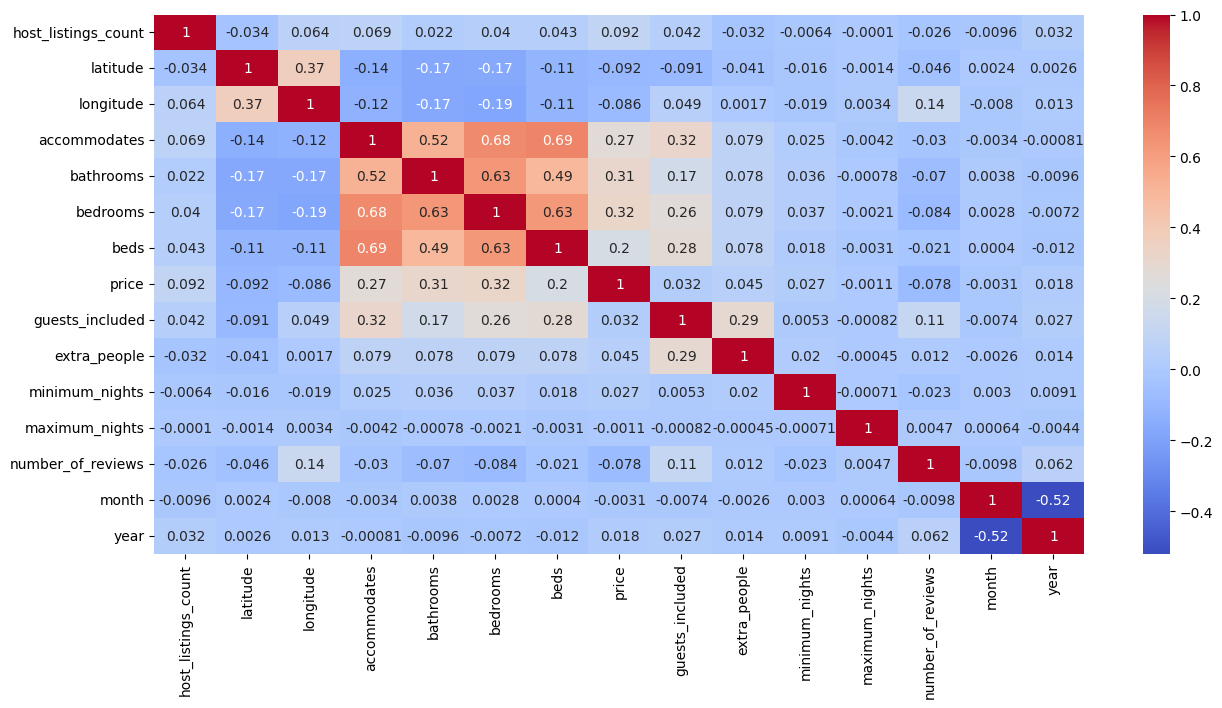

In [16]:
# Selecione apenas colunas numéricas
numeric_cols = base_airbnb_limpo.select_dtypes(include=[np.number])

# Plot o mapa de calor
plt.figure(figsize=(15, 7))
sns.heatmap(numeric_cols.corr(), annot=True, cmap='coolwarm')

# Print matrix de correlação
plt.show()


Ao analisar a matriz de correlação no DataFrame, percebe-se que nenhuma coluna apresenta uma correlação extremamente forte que possa prejudicar a análise. As colunas que apresentam correlações significativas estão alinhadas de forma lógica com o contexto do dataset, o que significa que essas relações fazem sentido no cenário estudado.

Isso significa que, ao realizar análises como o uso de métodos de machine learning ou cálculos estatísticos, não há colunas com correlação tão alta que poderiam redundar em problemas de multicolinearidade. Em muitos casos, a presença de correlações moderadas pode até ser benéfica, pois pode indicar relações esperadas entre variáveis que estão interligadas naturalmente no problema que está sendo analisado.


### **Como forma de  economiza tempo, evitar a repetição desnecessária de código, e melhora a produtividade, será criada funções que serão utilizadas diversas vezes no decorrer da análise.**

In [17]:
def limites(coluna):
    q1 = base_airbnb_limpo[coluna].quantile(0.25)
    q3 = base_airbnb_limpo[coluna].quantile(0.75)
    amplitude = q3 - q1
    return [q1 - 1.5 * amplitude, q3 + 1.5 * amplitude]

def excluir_outliers(df, coluna):
    qte_linhas = df.shape[0]

    limi_inf, limi_sup = limites(coluna)

    df_filtrado = df[(df[coluna] >= limi_inf) & (df[coluna] <= limi_sup)]

    linhas_removidas = qte_linhas - df_filtrado.shape[0]

    return df_filtrado, linhas_removidas

def box_plot(coluna):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(10, 5)

    # Passar o DataFrame e a coluna explicitamente
    sns.boxplot(data=base_airbnb_limpo, x=coluna, ax=ax1)
    ax2.set_xlim(limites(coluna))
    sns.boxplot(data=base_airbnb_limpo, x=coluna, ax=ax2)

    ax1.set_title('Box Plot - Todos os Dados')
    ax2.set_title('Box Plot - Limites Relevantes')


    return fig

def displot(coluna):
    ax = sns.displot(data=base_airbnb_limpo, x=coluna, kde=True, height=7, aspect=1.5)
    plt.title(f'Histograma - Distribuição de "{coluna}"')
    return plt

def histogram(coluna):
    plt.figure(figsize=(15, 5))
    plt.title(f'Histograma - Distribuição de "{coluna}"')

    return plt

def bar_plot(coluna):
    plt.figure(figsize=(15, 5))
    ax = sns.barplot(x=base_airbnb_limpo[coluna].value_counts().index, y=base_airbnb_limpo[coluna].value_counts())
    ax.set_xlim(limites(coluna))
    plt.title(f'Distribuição de "{coluna}"')
    plt.xlabel(coluna)
    plt.ylabel("Frequência")
    return plt

**Análise e  Exclusão de Outliers**

Primeiramente, para cada coluna númerica do DataFrame (`base_airbnb_limpo`), será feita uma análise detalhada da distribuição dos dados. Após entender como os valores estão distribuídos, será realizada a exclusão de **outliers**.

- **Distribuição de Dados**:  
    - O objetivo é entender como os dados estão distribuídos para cada coluna discreta, como `price`, `extra_people`, `beds`, `guest_included`, etc. Gráficos como **boxplots** e **histogramas** são utilizados para visualizar essas distribuições e identificar quaisquer anomalias ou concentrações atípicas nos dados.

- **Exclusão de Outliers**:  
    - Após a análise das distribuições, serão aplicados métodos para remover **outliers** nas colunas discretas. O critério geralmente utilizado é baseado no cálculo dos limites inferior e superior, que considera 1.5 vezes a amplitude interquartílica (Q3 - Q1). Assim, qualquer valor fora desses limites será considerado como um outlier e removido do conjunto.

### Por que fazer isso:
- **Melhoria na precisão da análise**: Ao remover outliers, evita-se que dados atípicos distorçam as estatísticas, gráficos e modelos preditivos.
- **Dados mais representativos**: Após a limpeza, as colunas discretas contêm informações mais consistentes e confiáveis, o que facilita análises mais precisas.
- **Qualidade dos dados**: Colunas com dados mais equilibrados e representativos garantem resultados mais robustos em futuras análises e modelagem.

Assim, ao realizar essa sequência de passos, o foco está em garantir dados limpos e mais precisos para análises futuras.

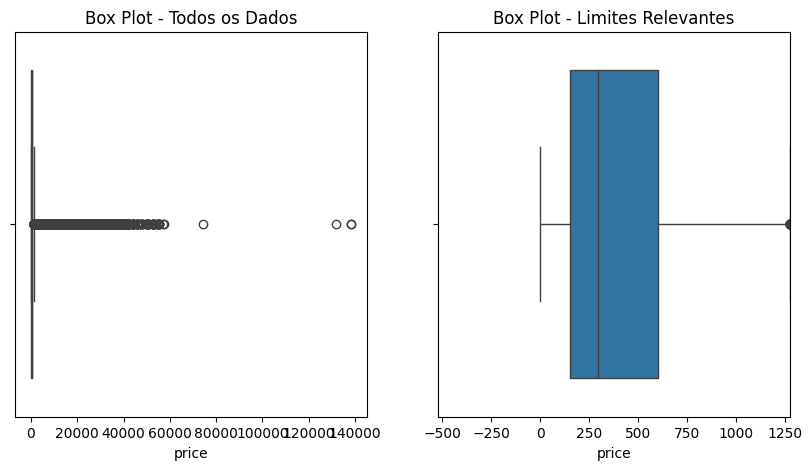

In [18]:
# price

box_plot('price')
plt.show()

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

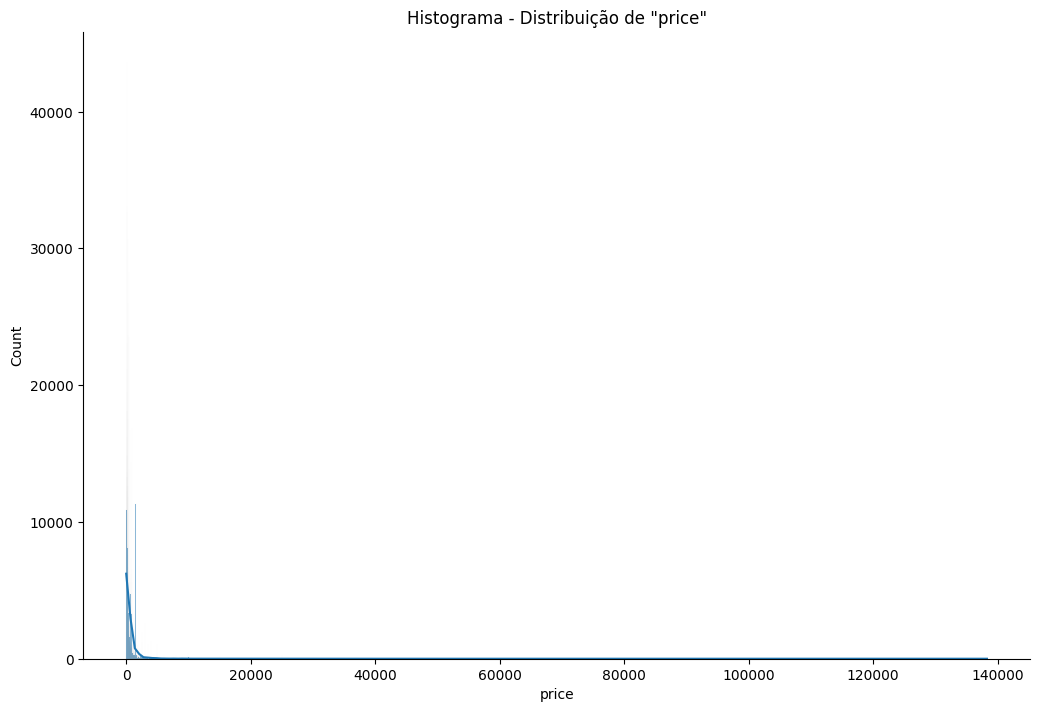

In [19]:
displot('price')

In [20]:
base_airbnb_limpo, linhas_removidas = excluir_outliers(base_airbnb_limpo, 'price')
print(f"Linhas removidas: {linhas_removidas}")
print(base_airbnb_limpo['price'].describe())

Linhas removidas: 87282
count    810427.000000
mean        353.888794
std         284.109680
min           0.000000
25%         149.000000
50%         251.000000
75%         491.000000
max        1276.000000
Name: price, dtype: float64


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

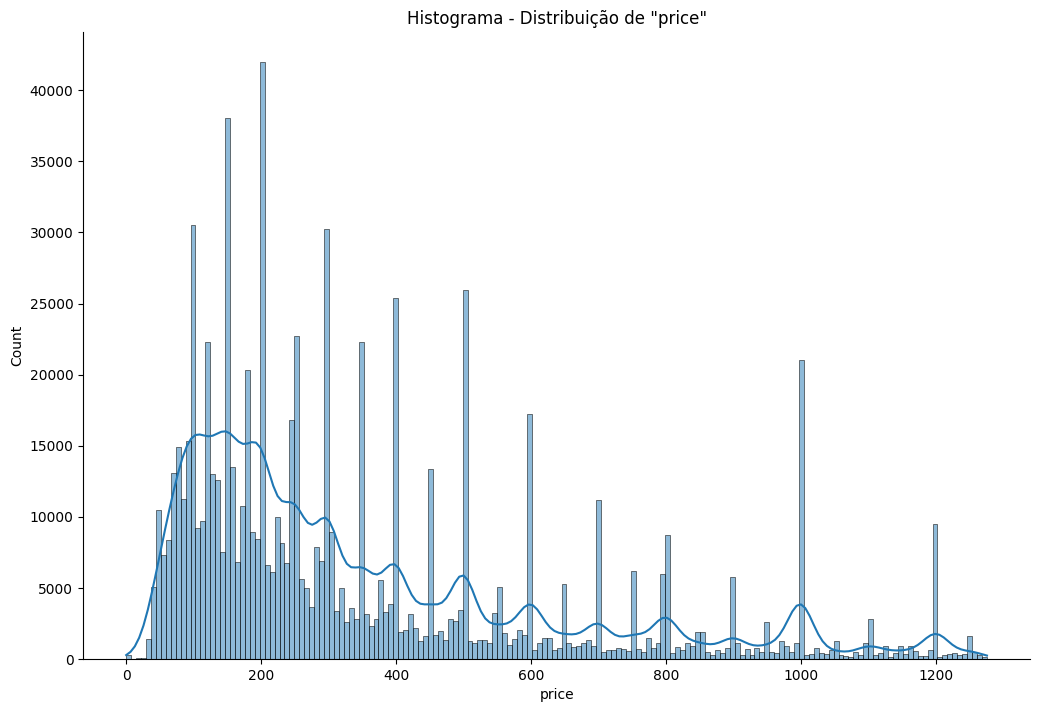

In [21]:
# Displot - Distribuição de 'price' após exclusão de Outliers

displot('price')


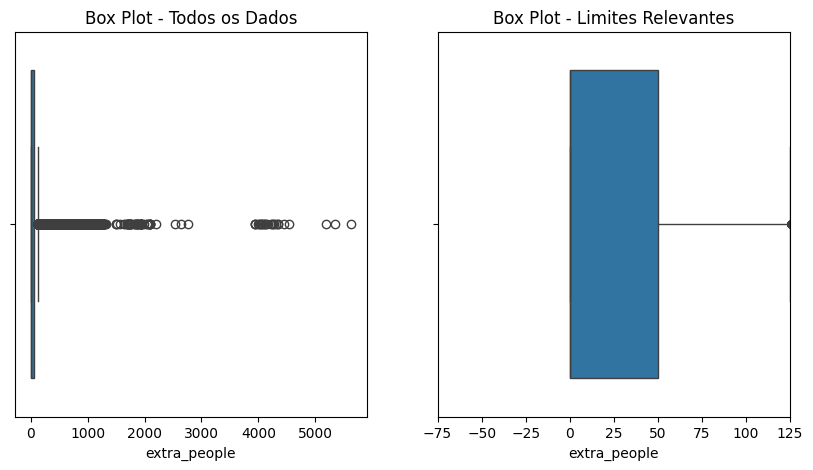

In [22]:
# extra_people
box_plot('extra_people')
plt.show()


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

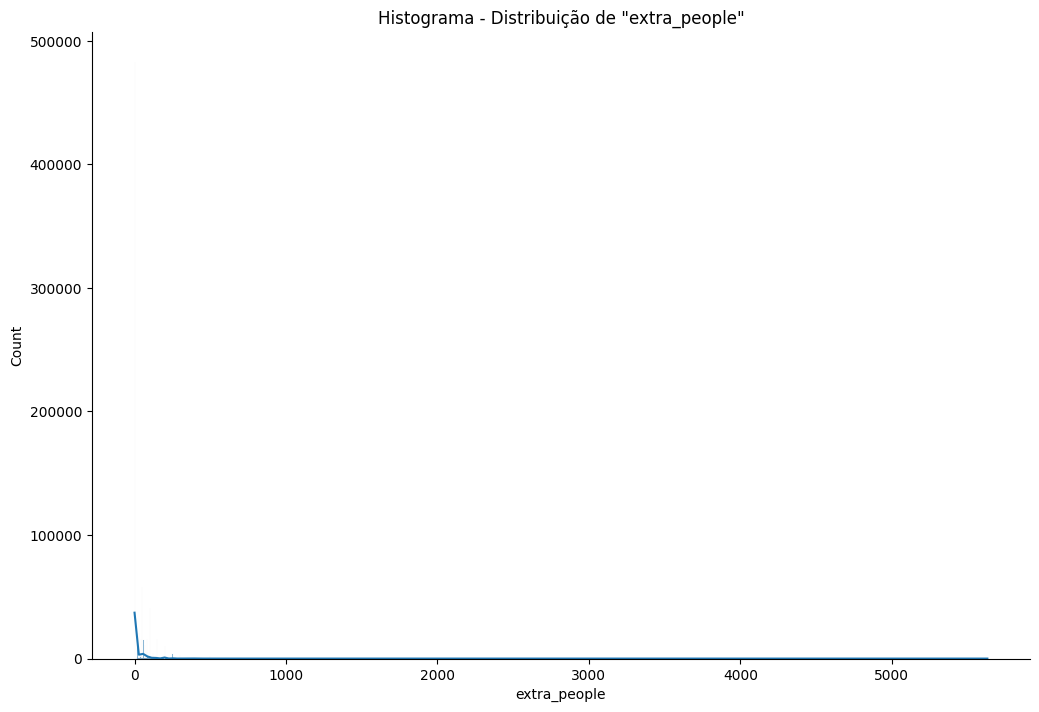

In [23]:
displot('extra_people')

In [24]:
base_airbnb_limpo, linhas_removidas = excluir_outliers(base_airbnb_limpo, 'extra_people')
print(f"Linhas removidas: {linhas_removidas}")
print(base_airbnb_limpo['extra_people'].describe())




Linhas removidas: 59194
count    751233.000000
mean         21.729952
std          33.396244
min           0.000000
25%           0.000000
50%           0.000000
75%          45.000000
max         125.000000
Name: extra_people, dtype: float64


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

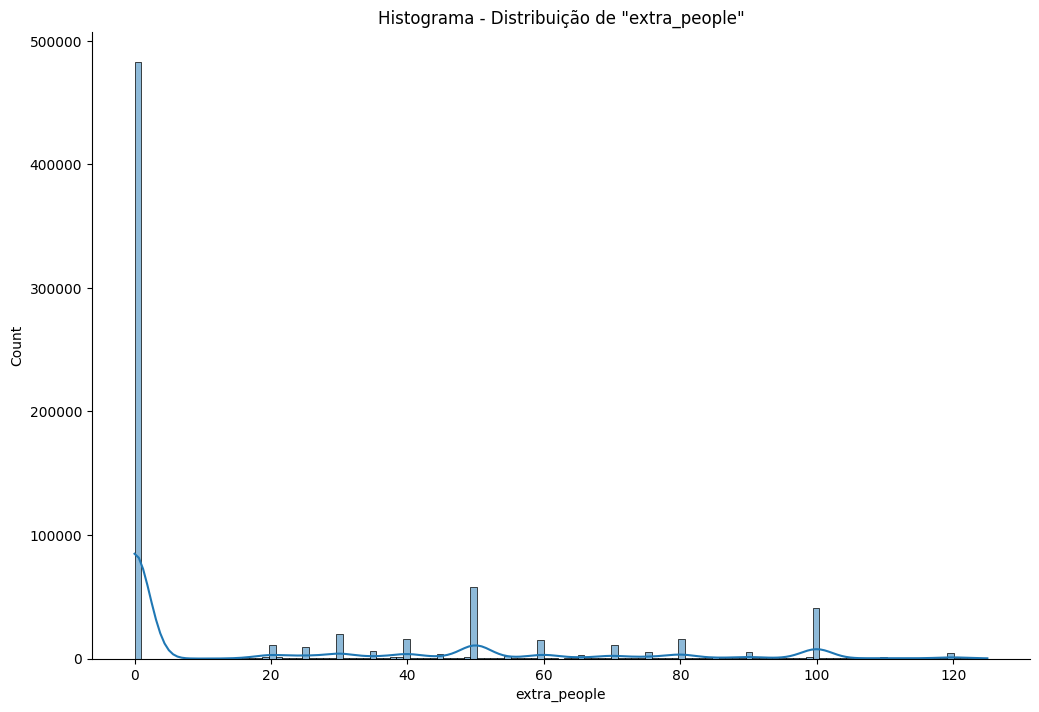

In [25]:
# Histograma - Distribuição de 'extra_people' após exclusão de Outliers

displot('extra_people')

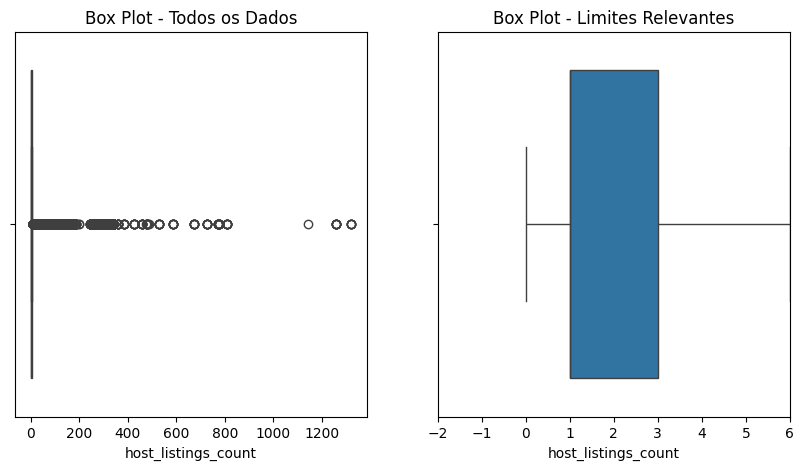

In [26]:
# host_listings_count
box_plot('host_listings_count')
plt.show()

A coluna `host_listings_count` refere-se ao número de listagem que o anfitrião (host) tem na plataforma do Airbnb.

Ela representa quantos imóveis diferentes um anfitrião possui disponíveis para aluguel.

Para analisar essa coluna e as próximas com dados semelhantes utilizaremos o gráfico de barras pois ele mostra a frequência de cada número de listagens. O `bar_plot` oferece uma visão clara da contagem de hosts com diferentes números de listagens, tornando-o mais eficiente para esse tipo de dado discreto.

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

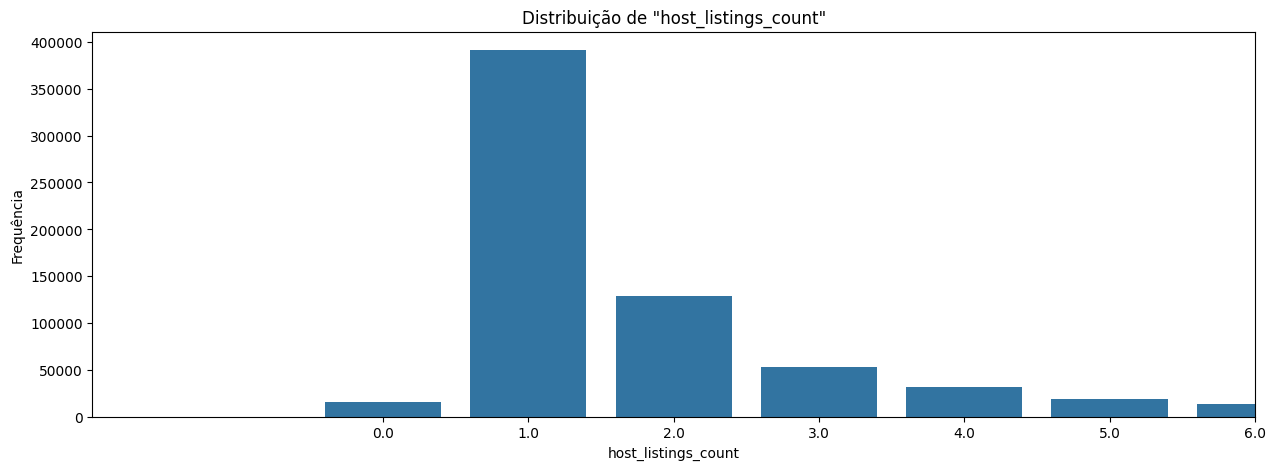

In [27]:
bar_plot('host_listings_count')

In [28]:
base_airbnb_limpo, linhas_removidas = excluir_outliers(base_airbnb_limpo, 'host_listings_count')
print(f"Linhas removidas: {linhas_removidas}")
print(base_airbnb_limpo['host_listings_count'].describe())

Linhas removidas: 97723
count    653510.000000
mean          1.699659
std           1.213740
min           0.000000
25%           1.000000
50%           1.000000
75%           2.000000
max           6.000000
Name: host_listings_count, dtype: float64


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

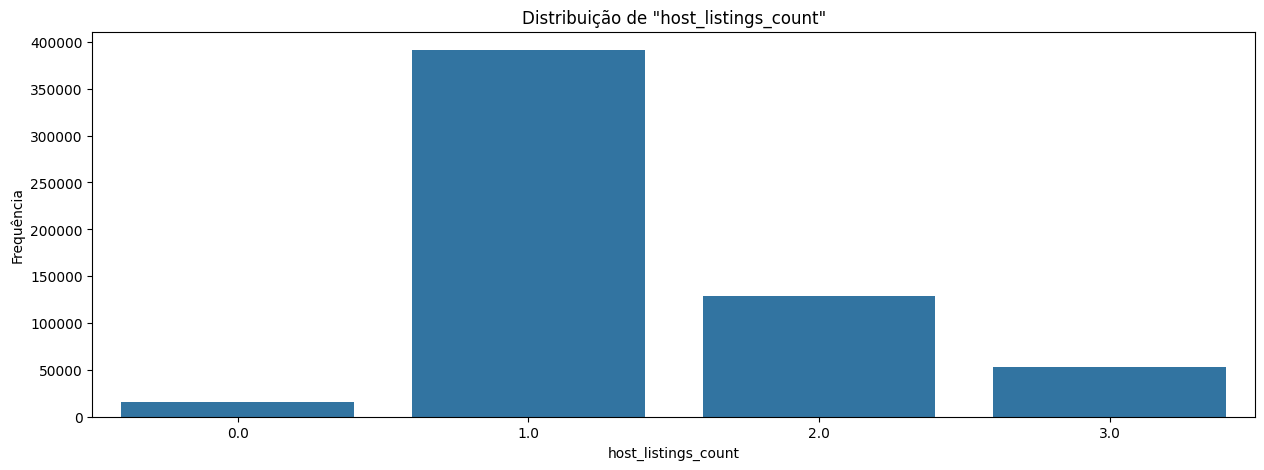

In [29]:
# Bar_plot - Distribuição de 'host_listings_count' após exclusão de Outliers

bar_plot('host_listings_count')

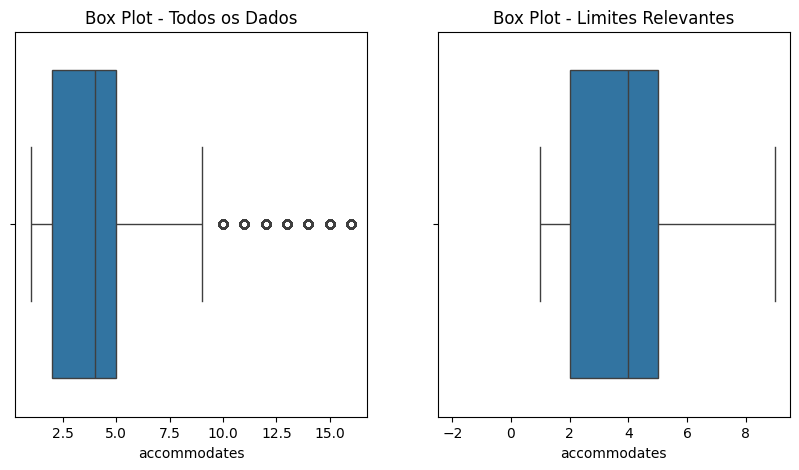

In [30]:
# accommodates

box_plot('accommodates')
plt.show()

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

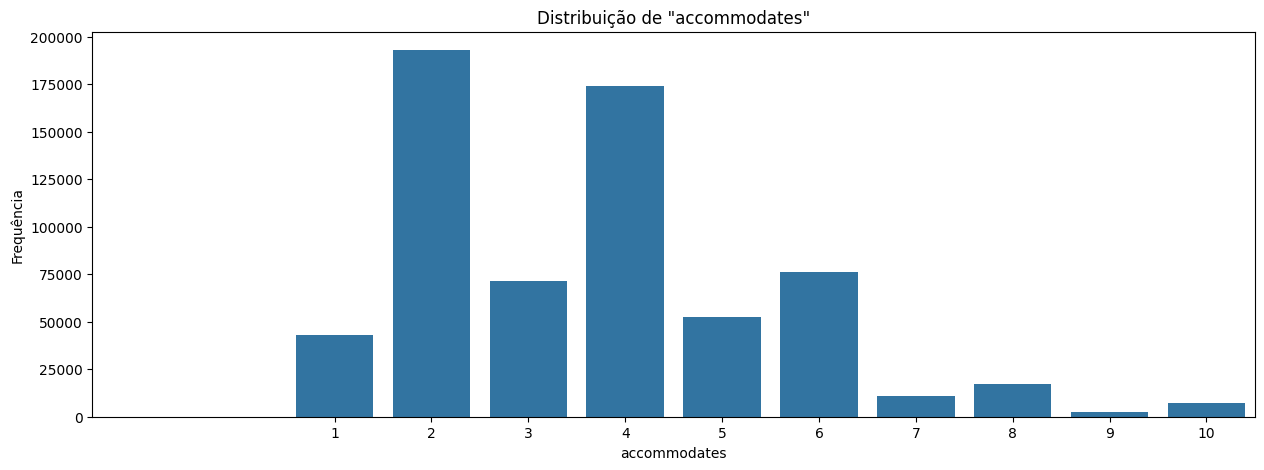

In [31]:
bar_plot('accommodates')

In [32]:
base_airbnb_limpo, linhas_removidas = excluir_outliers(base_airbnb_limpo, 'accommodates')
print(f"Linhas removidas: {linhas_removidas}")
print(base_airbnb_limpo['accommodates'].describe())



Linhas removidas: 13146
count    640364.000000
mean          3.583362
std           1.728271
min           1.000000
25%           2.000000
50%           4.000000
75%           4.000000
max           9.000000
Name: accommodates, dtype: float64


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

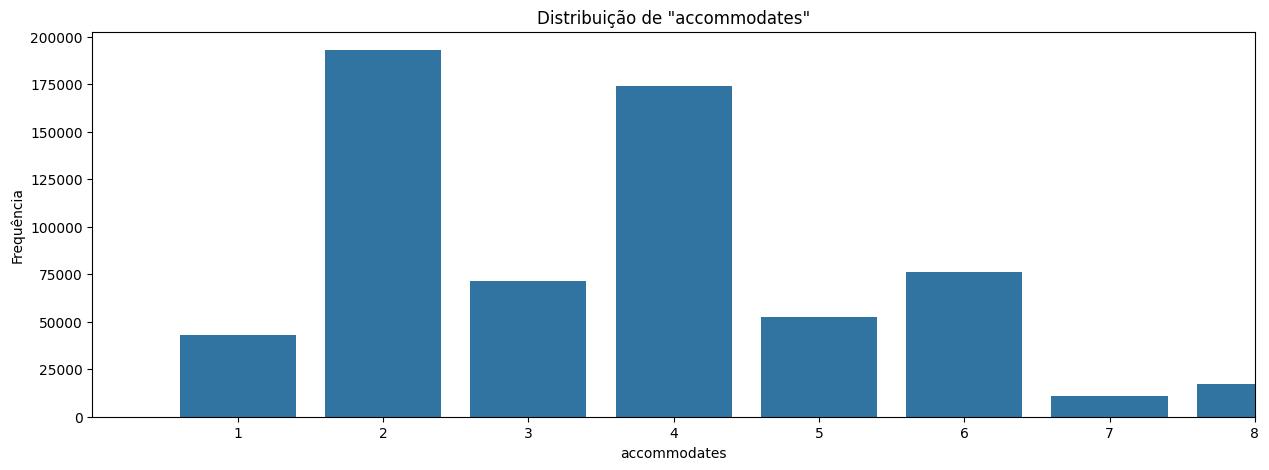

In [33]:
# Bar_plot - Distribuição de 'accommodates' após exclusão de Outliers

bar_plot('accommodates')

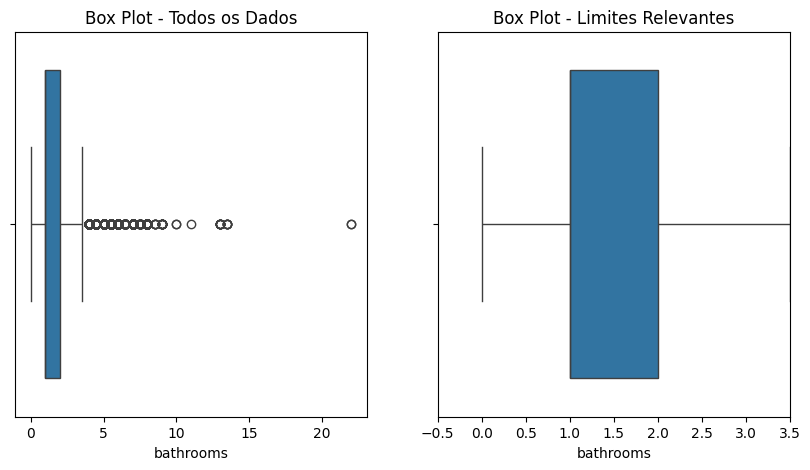

In [34]:
# bathrooms

box_plot('bathrooms')
plt.show()



<Axes: xlabel='bathrooms', ylabel='count'>

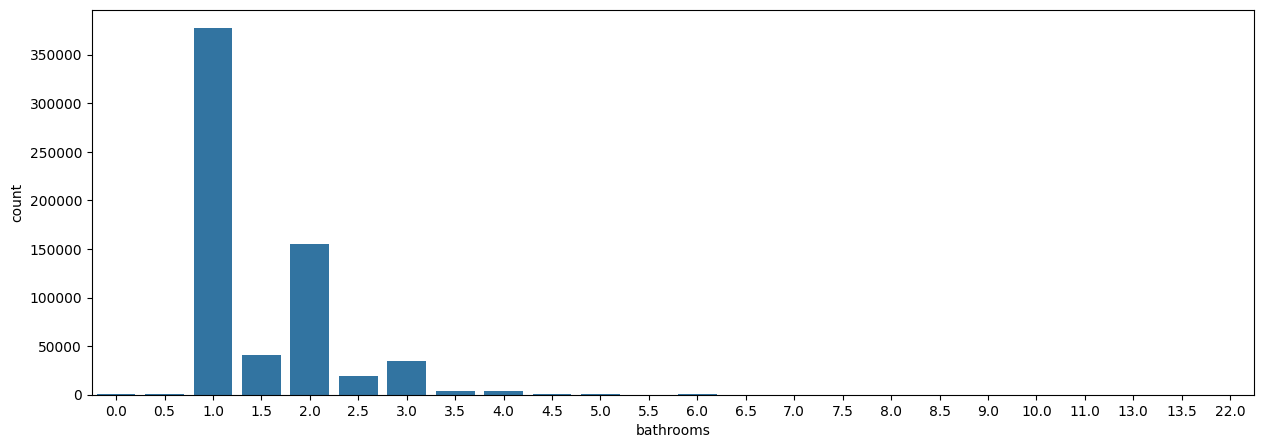

In [35]:
plt.figure(figsize=(15,5))
sns.barplot(x=base_airbnb_limpo['bathrooms'].value_counts().index, y=base_airbnb_limpo['bathrooms'].value_counts())


In [36]:
base_airbnb_limpo, linhas_removidas = excluir_outliers(base_airbnb_limpo, 'bathrooms')
print(f"Linhas removidas: {linhas_removidas}")
print(base_airbnb_limpo['bathrooms'].describe())

Linhas removidas: 6894
count    633470.000000
mean          1.445963
std           0.626311
min           0.000000
25%           1.000000
50%           1.000000
75%           2.000000
max           3.500000
Name: bathrooms, dtype: float64


<Axes: xlabel='bathrooms', ylabel='count'>

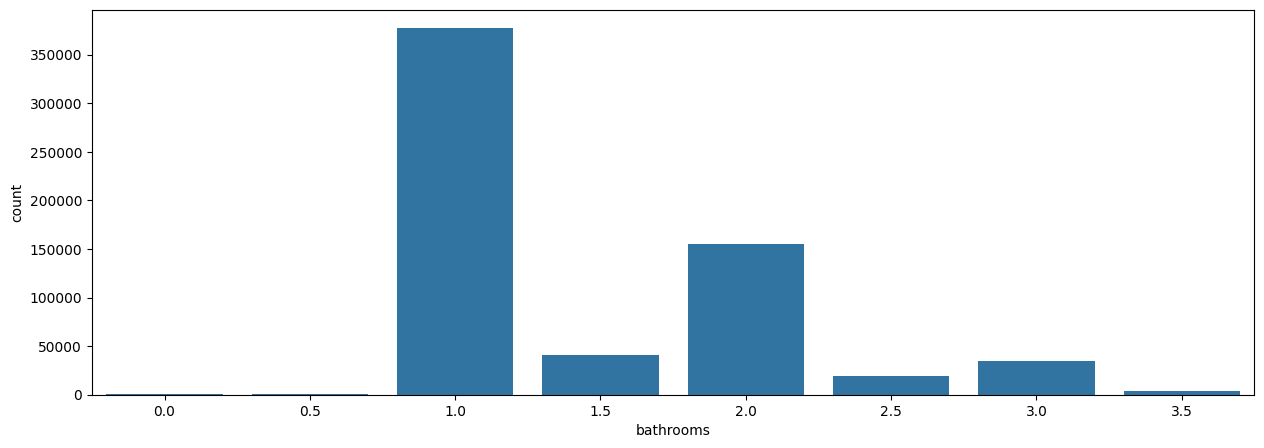

In [37]:
# Bar_plot - Distribuição de 'bathrooms' após exclusão de Outliers

plt.figure(figsize=(15,5))
sns.barplot(x=base_airbnb_limpo['bathrooms'].value_counts().index, y=base_airbnb_limpo['bathrooms'].value_counts())

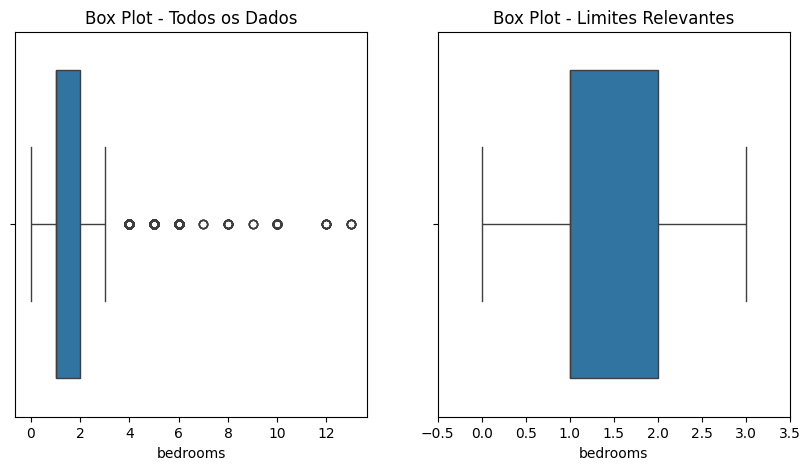

In [38]:
# bedrooms

box_plot('bedrooms')
plt.show()

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

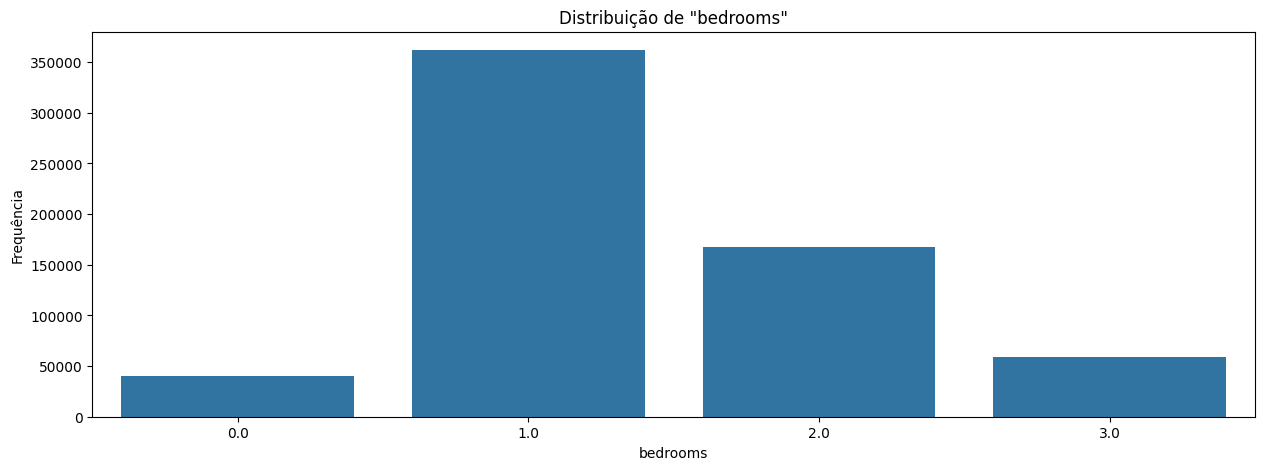

In [39]:
bar_plot('bedrooms')

In [40]:
base_airbnb_limpo, linhas_removidas = excluir_outliers(base_airbnb_limpo, 'bedrooms')
print(f"Linhas removidas: {linhas_removidas}")
print(base_airbnb_limpo['bedrooms'].describe())

Linhas removidas: 5482
count    627988.000000
mean          1.387888
std           0.743386
min           0.000000
25%           1.000000
50%           1.000000
75%           2.000000
max           3.000000
Name: bedrooms, dtype: float64


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

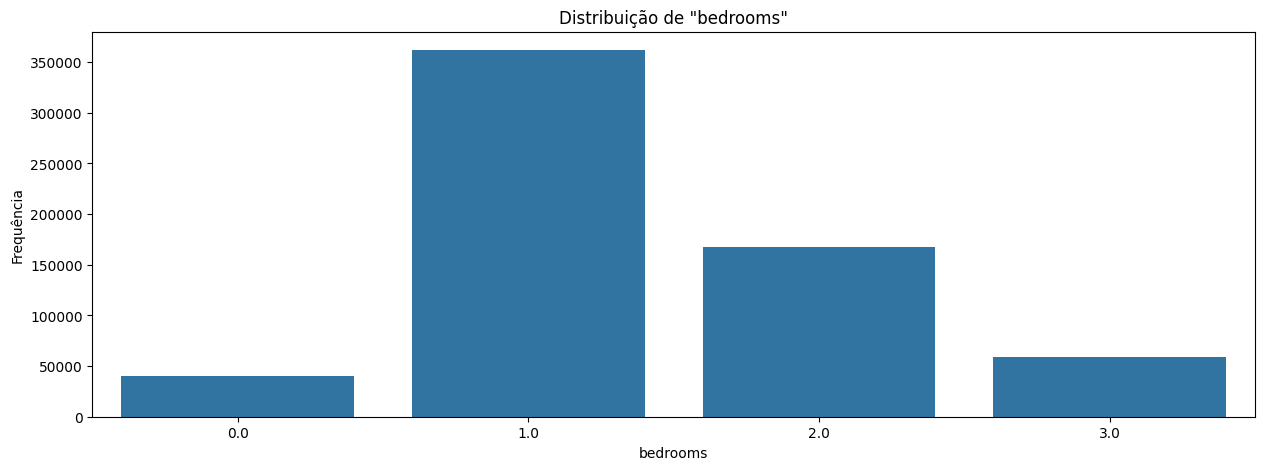

In [41]:
# Bar_plot - Distribuição de 'bedrooms' após exclusão de Outliers

bar_plot('bedrooms')

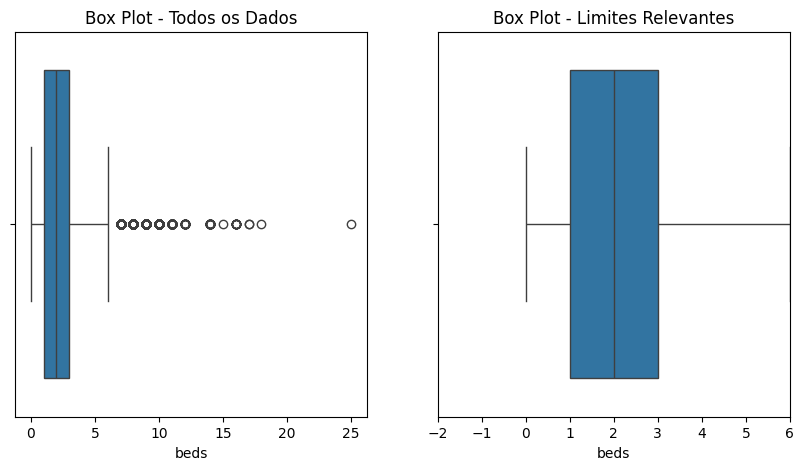

In [42]:
# beds

box_plot('beds')
plt.show()


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

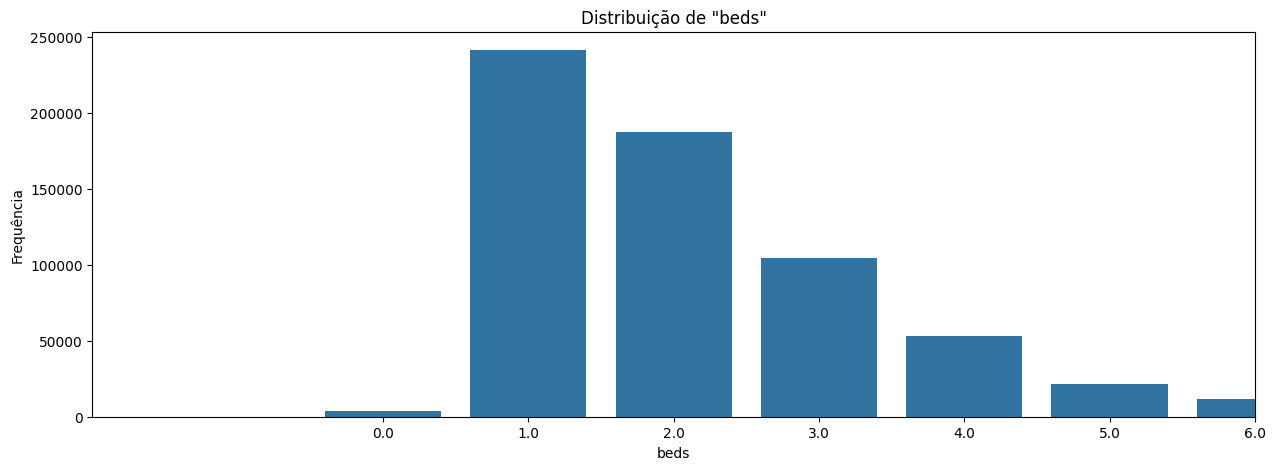

In [43]:
bar_plot('beds')

In [44]:
base_airbnb_limpo, linhas_removidas = excluir_outliers(base_airbnb_limpo, 'beds')
print(f"Linhas removidas: {linhas_removidas}")
print(base_airbnb_limpo['beds'].describe())

Linhas removidas: 5622
count    622366.000000
mean          2.116756
std           1.230153
min           0.000000
25%           1.000000
50%           2.000000
75%           3.000000
max           6.000000
Name: beds, dtype: float64


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

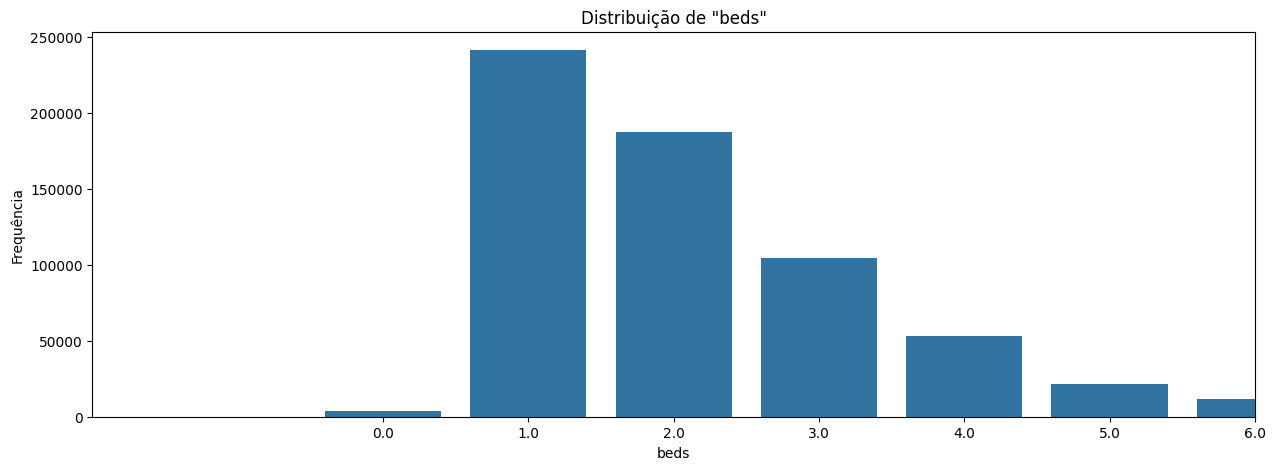

In [45]:
# Bar_plot - Distribuição de 'beds' após exclusão de Outliers

bar_plot('beds')

<ipython-input-17-277e7a34c1c7>:24: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax2.set_xlim(limites(coluna))


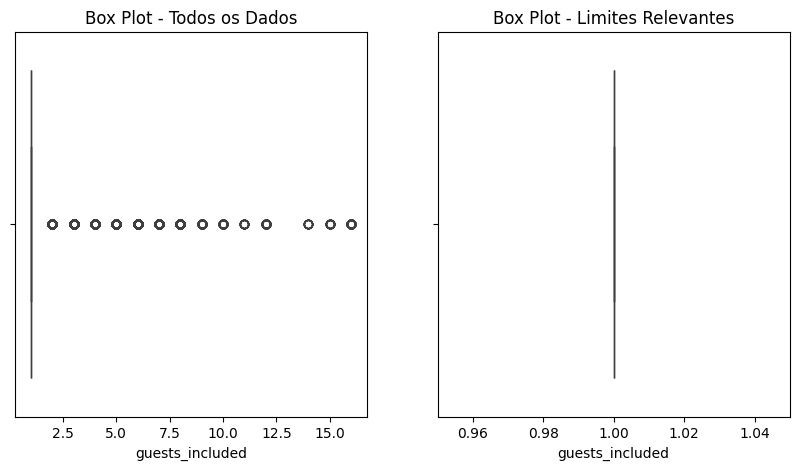

In [46]:
#  guests_included

box_plot('guests_included')
plt.show()


A coluna `guests_included` refere-se ao número de hóspedes que o preço listado no anúncio do Airbnb já inclui.

Ela indica quantas pessoas podem ser acomodadas pelo valor padrão da diária sem incluir custos adicionais por hóspedes extras.

  - Se um anúncio tem guests_included = 2, isso significa que o preço informado inclui acomodação para até 2 pessoas. Se houver mais hóspedes, pode haver um custo adicional.

  - O padrão predefinido para o campo `guests_included` no Airbnb geralmente é 2 hóspedes. Esse é o valor sugerido automaticamente pelo sistema para acomodações que não foram customizadas pelo anfitrião.

  - O limite relevante é 1, o que indica que apenas um hóspede está presente na maioria das entradas. Isso pode ser um indicativo de que essa coluna não traz muita informação relevante para a análise. Por esse motivo será descartada da análise.

In [47]:
base_airbnb_limpo = base_airbnb_limpo.drop('guests_included', axis=1)
base_airbnb_limpo.shape

(622366, 21)

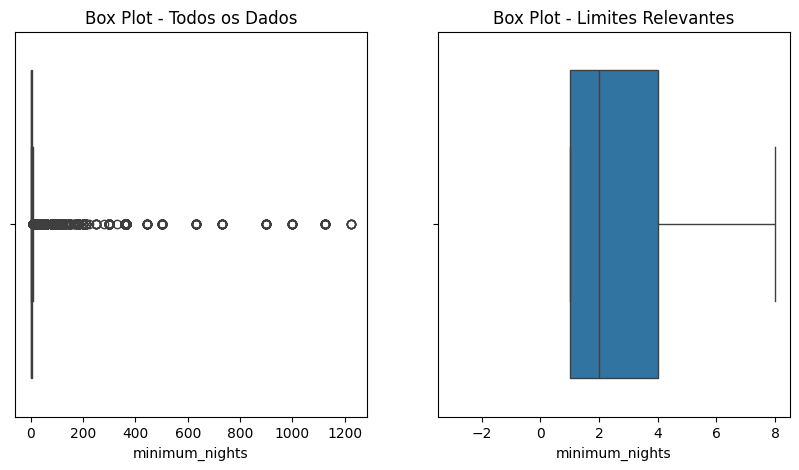

In [48]:
# minimum_nights

box_plot('minimum_nights')
plt.show()

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

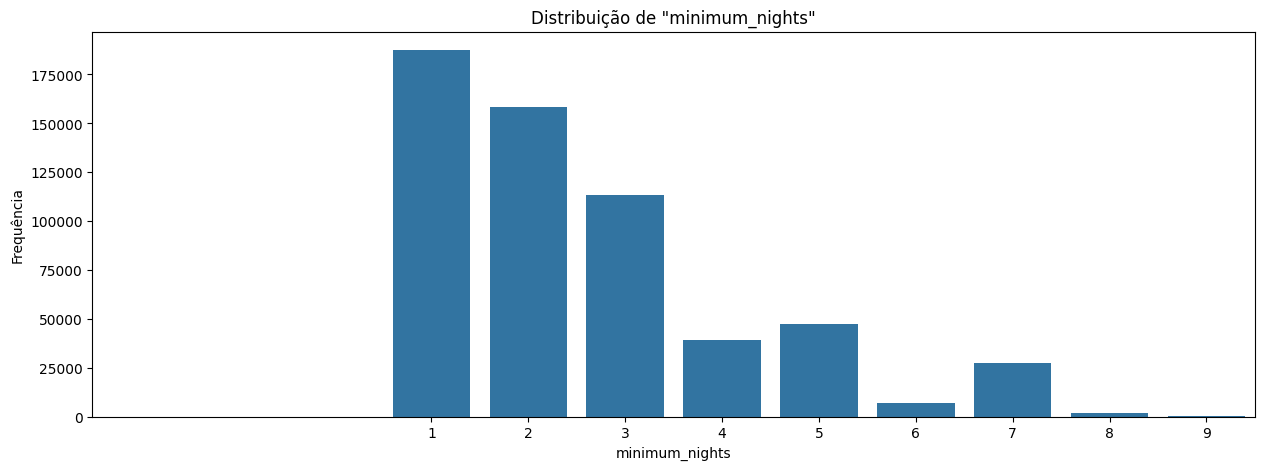

In [49]:
bar_plot('minimum_nights')

In [50]:
base_airbnb_limpo, linhas_removidas = excluir_outliers(base_airbnb_limpo, 'minimum_nights')
print(f"Linhas removidas: {linhas_removidas}")
print(base_airbnb_limpo['minimum_nights'].describe())

Linhas removidas: 40383
count    581983.000000
mean          2.551841
std           1.638559
min           1.000000
25%           1.000000
50%           2.000000
75%           3.000000
max           8.000000
Name: minimum_nights, dtype: float64


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

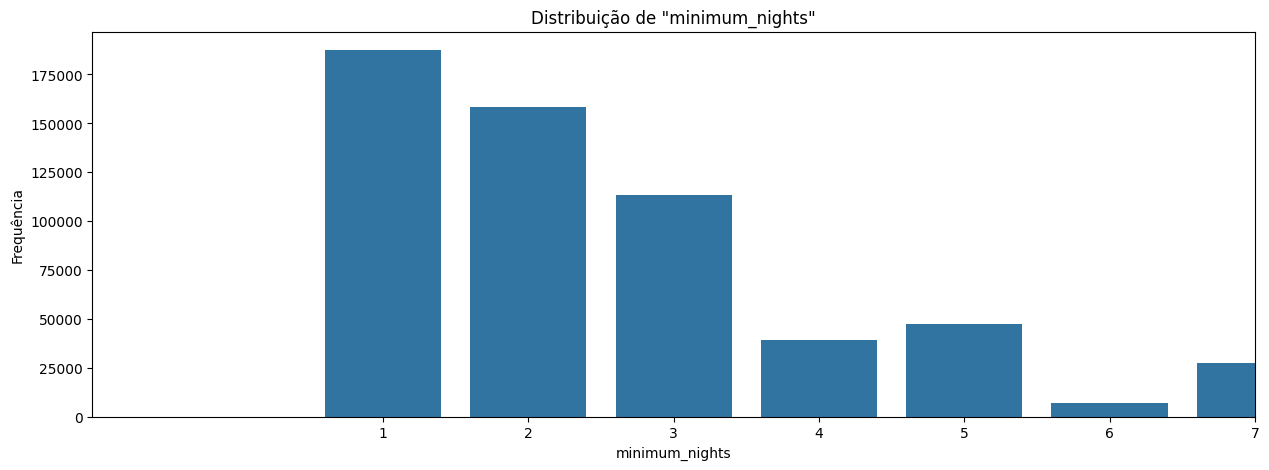

In [51]:
# Bar_plot - Distribuição de 'minimum_nights' após exclusão de Outliers

bar_plot('minimum_nights')

`maximum_nights` Indica o número máximo de noites que podem ser reservadas para um imóvel.

A análise é voltada para um host comum, a coluna `maximum_nights` pode não ser crucial para a previsão do preço para este host. A exclusão dessa coluna pode simplificar o modelo, removendo variáveis que não adicionam tanto valor.

Seguindo esse mesmo raciocínio, a coluna `number_of_reviews` indica o nível de feedback ou experiência acumulada para aquele imóvel. É útil para entender a popularidade ou reputação de uma propriedade, mas para um host comum que deseja precificar seu imóvel com base somente nas características dele, essa coluna não adicionara valor ao modelo. Portanto, essas colunas serão descartadas.

In [52]:
base_airbnb_limpo =  base_airbnb_limpo.drop('maximum_nights', axis=1)
base_airbnb_limpo =  base_airbnb_limpo.drop('number_of_reviews', axis=1)

# **Tratamento de Valores Categóricos da Coluna property_type**

A coluna `property_type` descreve o tipo de propriedade anunciada (por exemplo, apartamento, casa, quarto privado, etc.). Como essa coluna é categórica, é necessário tratá-la para que os modelos de análise ou machine learning consigam interpretá-la.

## Redução de Categorias

Algumas categorias podem ser muito raras ou semelhantes a outras. Nesse caso, faz sentido agrupá-las para evitar sparsity (esparsidade).
  - Exemplo: Consolidar "Chalé", "Cabana", e "Casa na Árvore" em uma categoria como "Propriedades Rústicas".
Isso simplifica a análise e evita que categorias com poucos dados tenham peso excessivo.


In [53]:
print(base_airbnb_limpo['property_type'].value_counts())

property_type
Apartment                 458354
House                      51387
Condominium                26456
Serviced apartment         12671
Loft                       12352
Guest suite                 3621
Bed and breakfast           3472
Hostel                      2665
Guesthouse                  2155
Other                       1957
Villa                       1294
Townhouse                    969
Aparthotel                   693
Chalet                       481
Earth house                  468
Tiny house                   457
Boutique hotel               447
Hotel                        376
Casa particular (Cuba)       298
Cottage                      230
Bungalow                     207
Dorm                         185
Cabin                        141
Nature lodge                 124
Castle                        80
Treehouse                     76
Island                        54
Boat                          53
Hut                           40
Campsite                     

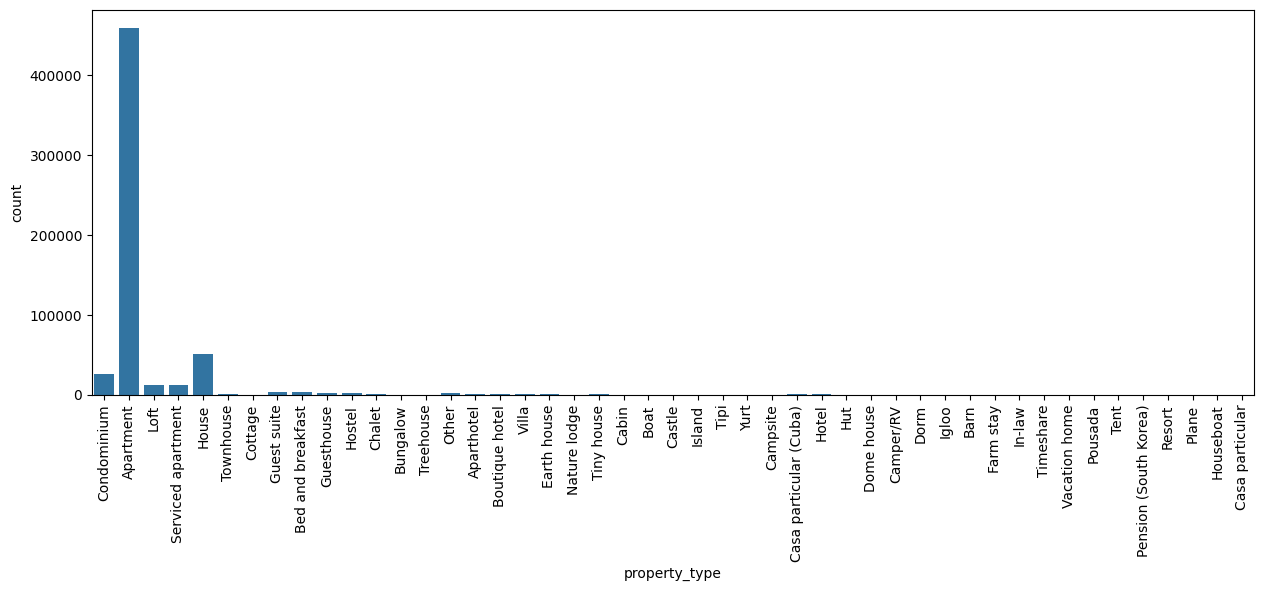

In [54]:
plt.figure(figsize=(15, 5))
graph = sns.countplot(x='property_type', data=base_airbnb_limpo)
graph.tick_params(axis='x', rotation=90)

# **Consolidação de Categorias Raras na Coluna property_type**
Para simplificar a análise e evitar sparsity (esparsidade) nos dados, iremos consolidar categorias de `property_type` com menos de 4.000 ocorrências em uma única categoria chamada "other". Isso ajuda a manter a relevância das categorias mais representativas, enquanto reduz o impacto de categorias raras.

In [55]:
table = base_airbnb_limpo['property_type'].value_counts()
outhers_group = []

for type in table.index:
    if table[type] < 4000:
        outhers_group.append(type)
    else:
        continue

print(outhers_group)

for type in outhers_group:
    base_airbnb_limpo.loc[base_airbnb_limpo['property_type'] == type, 'property_type'] = "Others"


['Guest suite', 'Bed and breakfast', 'Hostel', 'Guesthouse', 'Other', 'Villa', 'Townhouse', 'Aparthotel', 'Chalet', 'Earth house', 'Tiny house', 'Boutique hotel', 'Hotel', 'Casa particular (Cuba)', 'Cottage', 'Bungalow', 'Dorm', 'Cabin', 'Nature lodge', 'Castle', 'Treehouse', 'Island', 'Boat', 'Hut', 'Campsite', 'Resort', 'Camper/RV', 'Yurt', 'Tent', 'Tipi', 'Barn', 'Farm stay', 'Pension (South Korea)', 'Dome house', 'In-law', 'Igloo', 'Vacation home', 'Timeshare', 'Pousada', 'Houseboat', 'Casa particular', 'Plane']


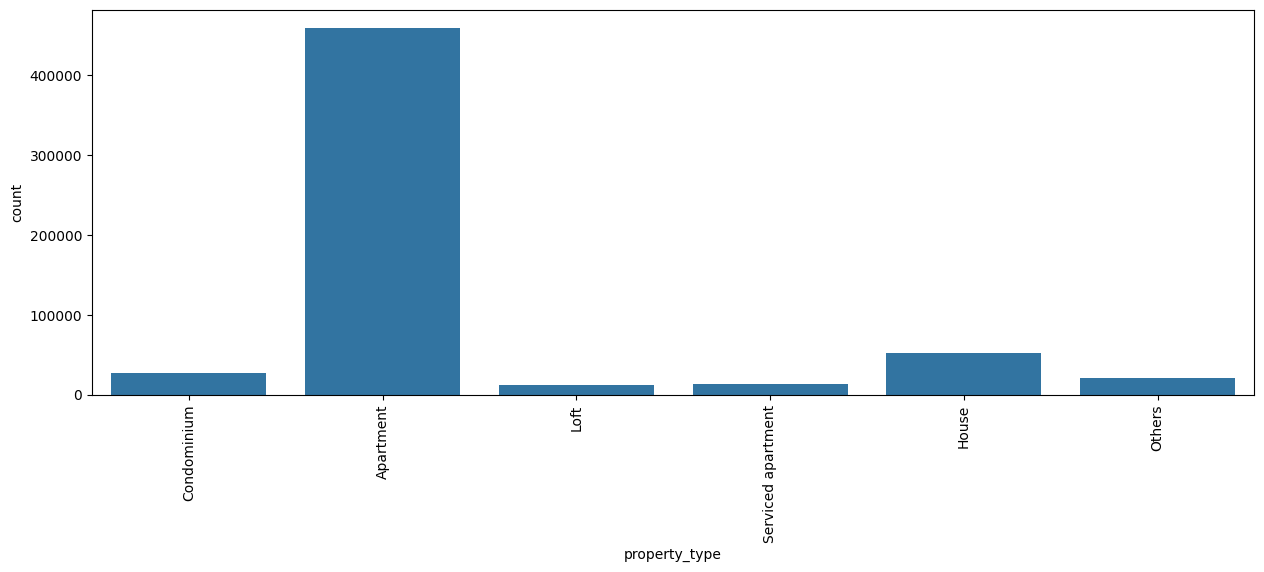

In [56]:
# Bar_plot - Distribuição de 'property_type' após consolidação


plt.figure(figsize=(15, 5))
graph = sns.countplot(x='property_type', data=base_airbnb_limpo)
graph.tick_params(axis='x', rotation=90)

## **Coluna amenities**
A coluna `amenities` no dataset do Airbnb lista os itens e serviços oferecidos por cada acomodação. Esses itens podem incluir desde comodidades básicas, como Wi-Fi e ar-condicionado, até luxos adicionais, como piscina e spa.

### **Relevância para a Análise**
**Impacto no Preço:**
  - amenities luxuosas ou adicionais podem aumentar significativamente o valor da propriedade.

**Preferências de Usuários:**
  - Certas amenities, como Wi-Fi ou estacionamento gratuito, são frequentemente procuradas pelos hóspedes.

**Modelagem:**
  - Analisar as amenities pode ajudar a prever a popularidade e o preço de uma propriedade.

Para lidar com a variabilidade e inconsistência da coluna `amenities`, uma abordagem prática é tratar o número total de amenidades listadas por cada host como um valor numérico. Essa simplificação permite incorporar as amenidades no modelo de análise como uma métrica quantitativa, representando a "quantidade de comodidades disponíveis".


In [57]:
base_airbnb_limpo['amenities_number'] = base_airbnb_limpo['amenities'].str.split(',').apply(len)


Após o tratamento da coluna amenities, transformando-a em uma métrica numérica (`amenities_number`), será possível realizar análises mais detalhadas e consistentes

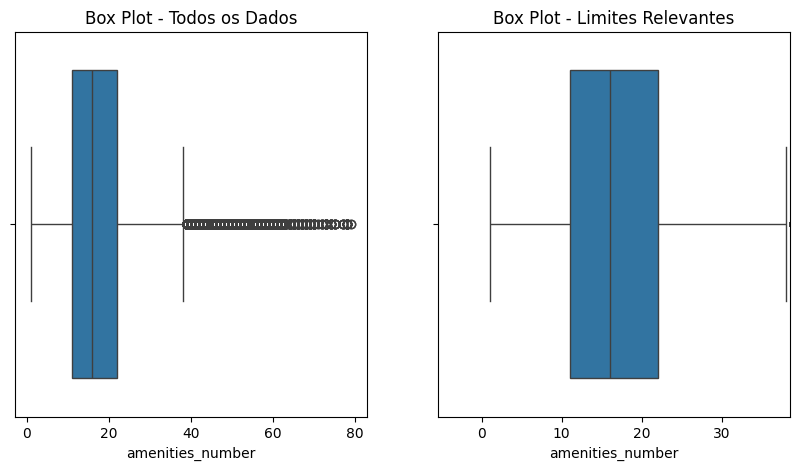

In [58]:
# amenities_number

box_plot('amenities_number')
plt.show()

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

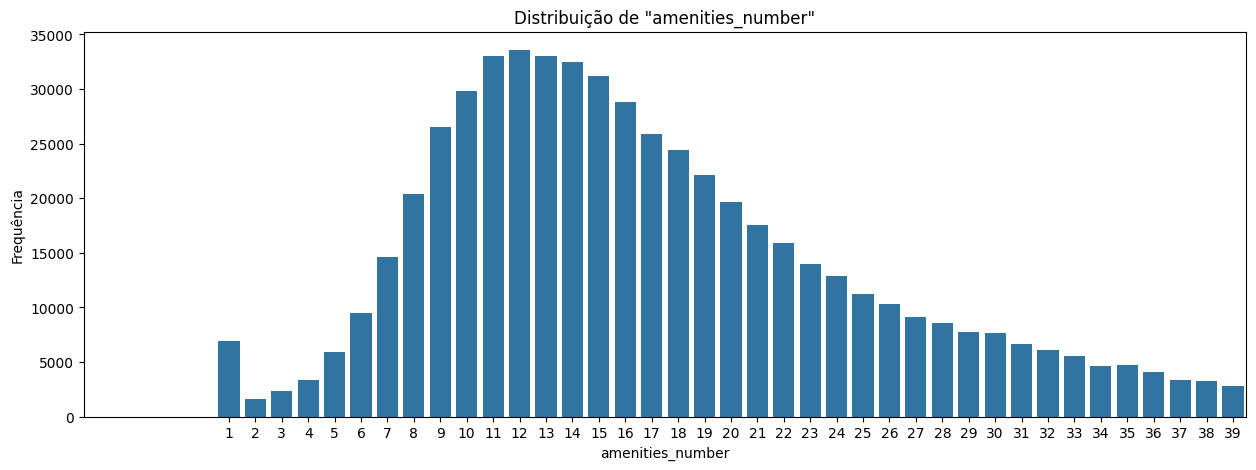

In [59]:
bar_plot('amenities_number')

In [60]:
base_airbnb_limpo, linhas_removidas = excluir_outliers(base_airbnb_limpo, 'amenities_number')
print(f"Linhas removidas: {linhas_removidas}")
print(base_airbnb_limpo['amenities_number'].describe())


Linhas removidas: 24343
count    557640.000000
mean         16.706063
std           7.752985
min           1.000000
25%          11.000000
50%          15.000000
75%          21.000000
max          38.000000
Name: amenities_number, dtype: float64


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

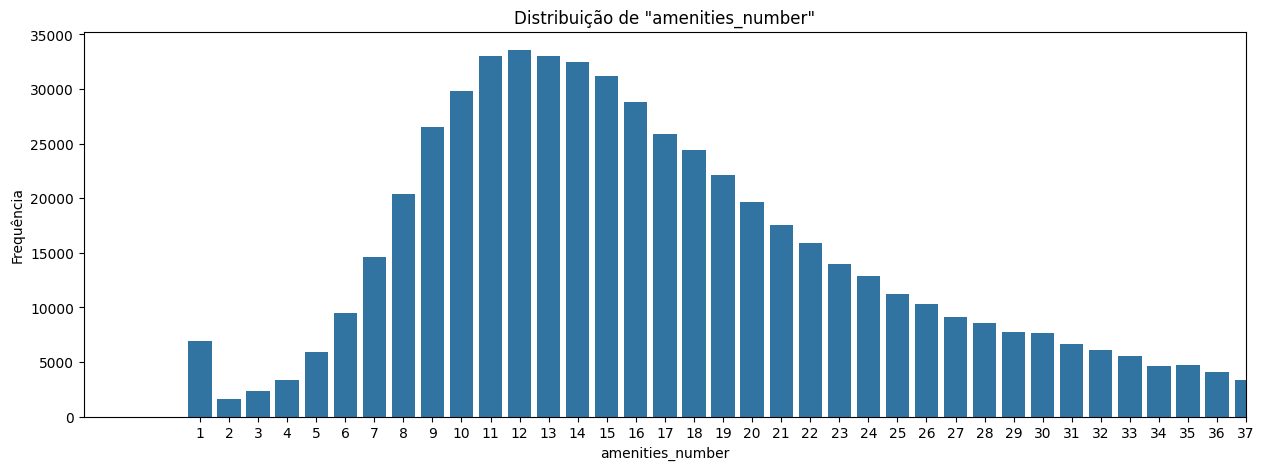

In [61]:
# Bar_plot - Distribuição de 'amenities_number' após exclusão de Outliers
bar_plot('amenities_number')

In [62]:
base_airbnb_limpo  = base_airbnb_limpo.drop('amenities', axis=1)

In [63]:
base_airbnb_limpo.head(1)

,host_is_superhost,host_listings_count,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,price,extra_people,minimum_nights,instant_bookable,is_business_travel_ready,month,year,amenities_number
0,False,2.0,-22.96592,-43.17896,Condominium,Entire home/apt,5,1.0,2.0,2.0,Real Bed,329.0,62.0,4,False,False,9,2019,33


# **Visualização de Mapa**

Após concluir o tratamento e análise das colunas numéricas e categóricas, o próximo passo será criar uma visualização geográfica para mostrar a localização dos imóveis e seus respectivos preços. Isso será feito utilizando as colunas de latitude e longitude presentes no dataframe.

## **Objetivo:**

  - Visualizar a distribuição geográfica dos imóveis em relação aos preços.
  - Identificar padrões ou clusters de imóveis com preços similares em determinadas áreas.
  - Auxiliar na compreensão espacial da base de dados, fornecendo insights adicionais para a análise.

In [64]:
display(base_airbnb_limpo[['latitude','longitude']].head(1))

,latitude,longitude
0,-22.96592,-43.17896


In [65]:
pio.renderers.default = 'notebook+iframe'

# Amostra de dados
amostra = base_airbnb_limpo.sample(n=50000)

# Centralizar o mapa
center = {'lat': base_airbnb_limpo.latitude.mean(), 'lon': base_airbnb_limpo.longitude.mean()}

# Criar o mapa interativo com fundo escuro
map = px.density_mapbox(amostra, lat='latitude', lon='longitude', z='price', radius=2.5, center=center, zoom=11.5, mapbox_style='carto-darkmatter')

map.write_html("mapa_interativo.html")


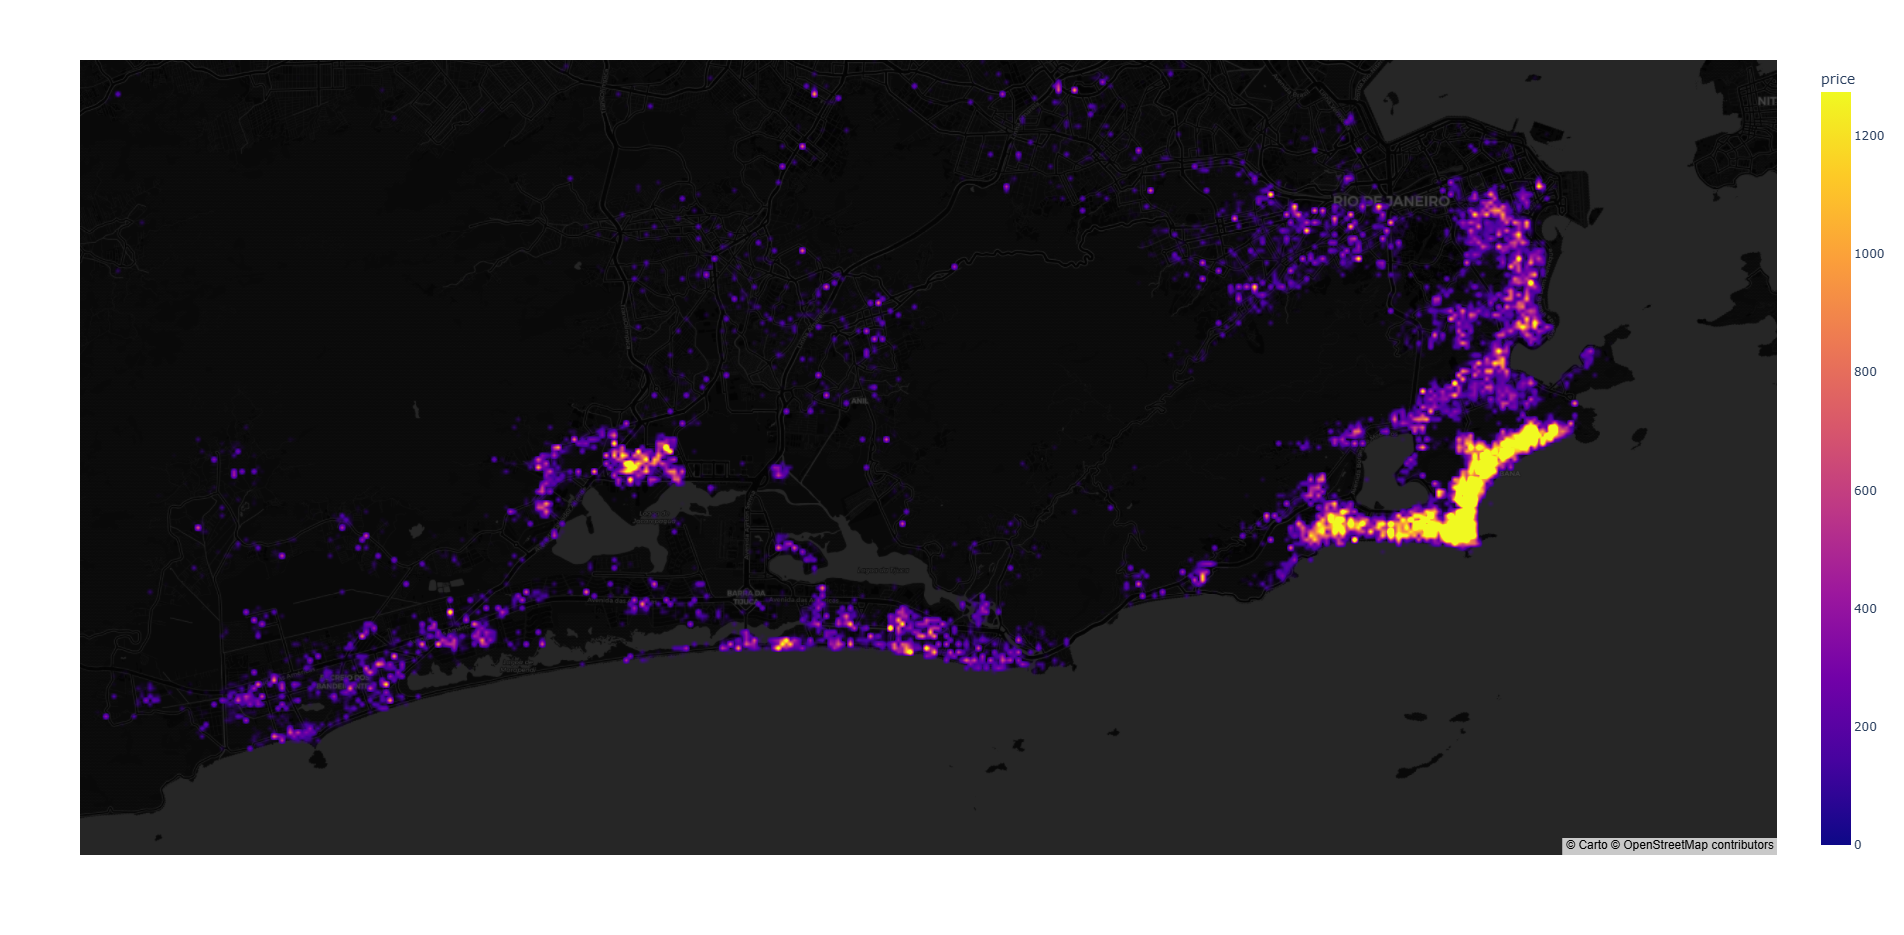

## **Encoding**

Encoding é o processo de converter variáveis categóricas (dados qualitativos) em uma representação numérica que pode ser entendida e processada por algoritmos de aprendizado de máquina. Como a maioria dos modelos trabalha com números, as variáveis categóricas precisam ser transformadas antes de serem usadas.

In [66]:
columns =  ['property_type','room_type','bed_type']
base_airbnb_limpo  = pd.get_dummies(data=base_airbnb_limpo, columns=columns)


In [67]:
display(base_airbnb_limpo.head())

,host_is_superhost,host_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,extra_people,...,property_type_Serviced apartment,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,bed_type_Airbed,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed
0,False,2.0,-22.96592,-43.17896,5,1.0,2.0,2.0,329.0,62.0,...,False,True,False,False,False,False,False,False,False,True
1,False,3.0,-22.97712,-43.19045,3,1.0,1.0,2.0,158.0,45.0,...,False,True,False,False,False,False,False,False,False,True
2,False,1.0,-22.98302,-43.21427,3,1.0,1.0,2.0,270.0,42.0,...,False,True,False,False,False,False,False,False,False,True
3,False,1.0,-22.98816,-43.19359,3,1.5,1.0,2.0,374.0,62.0,...,False,True,False,False,False,False,False,False,False,True
16,False,2.0,-22.92873,-43.17473,4,2.0,3.0,4.0,258.0,0.0,...,False,True,False,False,False,False,False,False,False,True


### Modelo de Previsão

- metricas de previsao

In [68]:
def review_model(model_name, y_test, predict):
    r2 = r2_score(y_test, predict)
    rsme = np.sqrt(mean_squared_error(y_test, predict))
    return f'Modelo {model_name}:\nR2:{r2:.2%}:\nRSME:{rsme:.2f}'

- Escolhas dos modelos
    - RandomForest
    - LinearRegression
    - Extratrees

In [69]:
RandomForest_model = RandomForestRegressor()
ExtraTrees_model = ExtraTreesRegressor()
LinearRegression_model = LinearRegression()
scaler_model = MinMaxScaler()

y = base_airbnb_limpo['price']
x = base_airbnb_limpo.drop('price', axis=1)

- Separar os moledos

In [70]:
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=42)

# **RandomForest_model**

In [71]:
RandomForest_model.fit(X_train, y_train)
predict = RandomForest_model.predict(X_test)

print(review_model(RandomForest_model, y_test, predict))

Modelo RandomForestRegressor():
R2:97.29%:
RSME:43.37


# **ExtraTrees_model**

In [72]:
ExtraTrees_model.fit(X_train, y_train)
predict = ExtraTrees_model.predict(X_test)

print(review_model(ExtraTrees_model, y_test, predict))

Modelo ExtraTreesRegressor():
R2:97.68%:
RSME:40.14


# Análise do Melhor Modelo

A análise apresentada compara o desempenho entre os modelos ExtraTreesRegressor e RandomForestRegressor para prever o preço dos imóveis. A comparação leva em consideração métricas de desempenho como o **R²** (Coeficiente de Determinação), o **RMSE** (Root Mean Squared Error - Erro Quadrático Médio) e o **tempo de execução**.


## Comparação entre os Modelos:

  - **ExtraTrees** mostrou um desempenho ligeiramente melhor em termos de R² e RMSE, com um tempo de execução mais rápido.

  - **RandomForest** também é bastante eficiente, mas apresentou um desempenho ligeiramente inferior no R² e no RMSE, embora o tempo de execução seja um pouco maior.

  O modelo **ExtraTreesRegressor** parece ser o mais adequado entre os dois devido ao seu desempenho ligeiramente superior e menor tempo de execução.

In [73]:
predict = ExtraTrees_model.predict(X_test)

print(predict)

[447.18 999.97 195.36 ... 600.37 199.4  320.73]


### Ajustes e Melhorias no Melhor Modelo

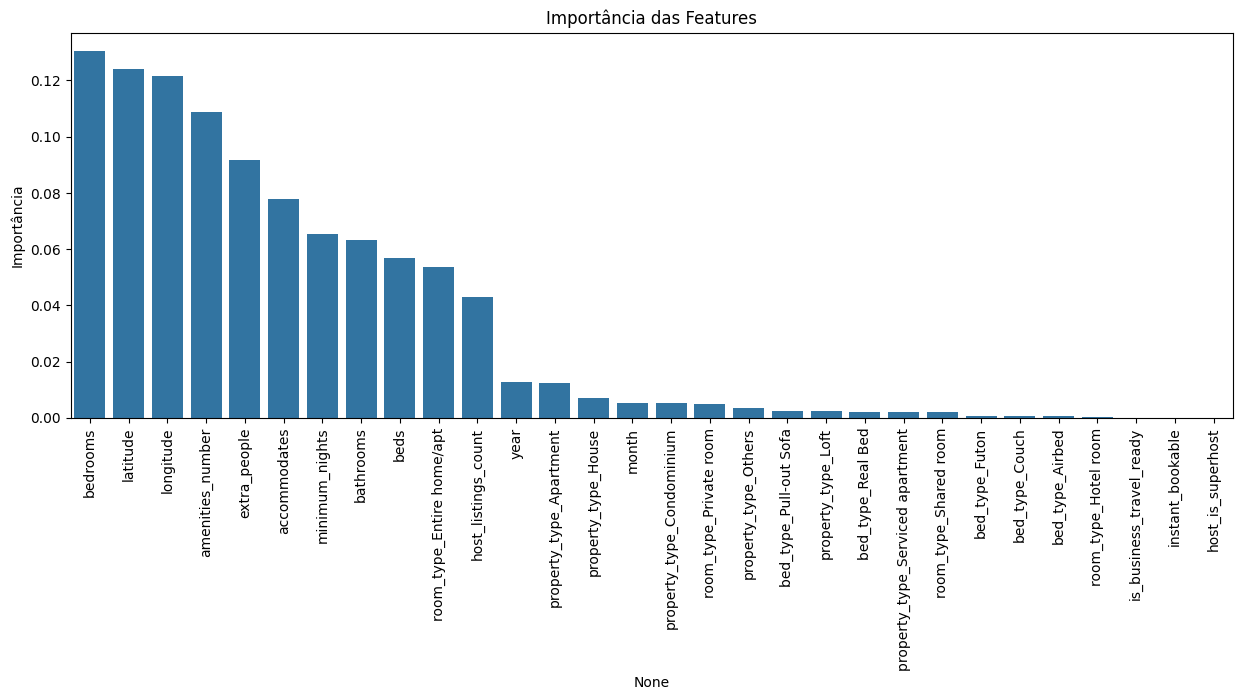

In [74]:
features =  pd.DataFrame(ExtraTrees_model.feature_importances_, index=X_train.columns, columns=['Importância'])

features.sort_values(by='Importância', ascending=False, inplace=True)

plt.figure(figsize=(15, 5))
sns.barplot(x=features.index, y=features['Importância'])
plt.title('Importância das Features')  # Define o título
plt.xticks(rotation=90)  # Rotaciona os rótulos do eixo X
plt.show()


# **Interpretação do Resultado do Modelo**

O modelo atribuiu valores de importância às features, indicando o peso de cada uma na determinação do resultado predito. Aqui está uma análise geral:

## **Features Mais Importantes:**

As features com maiores importâncias, como `latitude`, `longitude`, `bedrooms`, `amenities_number`, e `extra_people`, têm maior impacto no modelo. Isso significa que o modelo está usando essas variáveis com frequência para tomar decisões.

## **Features Menos Importantes:**

As features com valores muito próximos de zero, como `instant_bookable`, `host_is_superhost`, e `is_business_travel_ready`, têm impacto insignificante no modelo.
Isso indica que essas variáveis não contribuem de maneira significativa para melhorar a precisão do modelo.

In [75]:
# Teste 2

base_airbnb_mod =  base_airbnb_limpo.drop(['instant_bookable','host_is_superhost','is_business_travel_ready'], axis=1)

y = base_airbnb_mod['price']
X = base_airbnb_mod.drop('price', axis=1)


X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=42)



ExtraTrees_model.fit(X_train, y_train)
predict = ExtraTrees_model.predict(X_test)

print(review_model(ExtraTrees_model, y_test, predict))

Modelo ExtraTreesRegressor():
R2:97.69%:
RSME:40.05


# **Explicação dos Resultados**
Após excluir as colunas com features insignificantes, os resultados do modelo ExtraTreesRegressor foram quase idênticos:

## **Antes da exclusão de colunas:**

- **R² (Coeficiente de Determinação): 97,68%**

  - O modelo explica 97,68% da variação dos dados de teste em relação à variável alvo (y_test).
- **RMSE (Root Mean Square Error): 40,18**
  - O erro médio das previsões do modelo em relação aos valores reais é de aproximadamente 40,18 unidades.

## **Após a exclusão de colunas:**

- **R² (Coeficiente de Determinação): 97,68%**
  - O desempenho do modelo em termos de explicação da variabilidade não mudou.
- **RMSE (Root Mean Square Error): 40,16**
  - O erro médio diminuiu levemente, sugerindo uma melhoria marginal na precisão do modelo.

In [76]:
# Teste 3

base_airbnb_mod2 =  base_airbnb_mod[['latitude','longitude','bedrooms','amenities_number','extra_people','accommodates','room_type_Entire home/apt','bathrooms','minimum_nights','beds','host_listings_count','price']]


y = base_airbnb_mod2['price']
x = base_airbnb_mod2.drop('price', axis=1)


X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=42)



ExtraTrees_model.fit(X_train, y_train)
predict = ExtraTrees_model.predict(X_test)

print(review_model(ExtraTrees_model, y_test, predict))




Modelo ExtraTreesRegressor():
R2:97.25%:
RSME:43.74


# Na comparação entre os dois cenários:

## **Teste 2**
  - O modelo usa um conjunto maior de features.
  - Resultado: R²: 97.68% e RMSE: 40.16

## **Teste 3**

  - O modelo utiliza um subconjunto menor de features, focado apenas nas mais importantes.
  - Resultado: R²: 97.25% e RMSE: 43.73

Análise Detalhada:

- R² (Coeficiente de Determinação):

  - No primeiro caso, o R² é mais alto (97.68%), indicando que o modelo explica melhor o preço devido ao uso de um conjunto mais abrangente de variáveis.
  - No segundo caso, o R² caiu para 97.25%, indicando que o modelo focado apenas nas features selecionadas explica a variação, mas não com tanta precisão quanto o primeiro.

- RMSE (Root Mean Square Error):
  - O RMSE aumentou no segundo caso (43.73), indicando que o modelo simplificado não tem tanta precisão quanto o modelo com mais features.
  - O primeiro caso tem um RMSE mais baixo (40.16), indicando que o modelo está mais próximo das previsões reais.